In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky

from astropy.table import Table
from astropy.table import join
from scipy.optimize import minimize, curve_fit

In [3]:
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, vstack, hstack, join, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from datetime import datetime, timedelta

from scipy.ndimage import gaussian_filter1d

import os
from glob import glob

import psycopg2

from tqdm.notebook import tqdm_notebook

In [4]:
from hyperfit.linfit import LinFit

In [5]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

In [6]:
def firstdig(n):
    """Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    return np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)

def plot_radec(ra, dec):
    """Mollweide (map) projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    # Convert RA, Dec to radians.
    # Rotate the RA so that the plot goes 360->0 left to right.
    _ra = np.radians(120 - ra)
    _ra[_ra < -np.pi] += 2*np.pi
    _dec = np.radians(dec)

    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    ax.scatter(_ra, _dec, alpha=0.5, s=2)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['270', '240', '210', '180', '150', '120', '90', '60', '30', '0', '330'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    fig.tight_layout()
    
    return fig;

import requests

def get_cutout(targetid, ra, dec, width=300, height=300, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    os.makedirs('_cache', exist_ok=True)
    img_name = f'_cache/cutout_{targetid}_{width}_{height}.jpg'
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={ra}&dec={dec}&%22/pix=0.25&layer=ls-dr9&width={width}&height={height}&sga'
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the World Coordinate System.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.25/3600,
        'CRPIX1': width//2,
        'CRVAL1': ra,
        'NAXIS1': width,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.25/3600,
        'CRPIX2': height//2,
        'CRVAL2': dec,
        'NAXIS2': height
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [10]:
def clean_catalog(data):
    """Take a catalog matched to PV TF targets and apply quality cuts:
    * Keep only good redshifts (ZWARN==0, DELTACHI2>=25)
    * Ensure 1 main DESI TARGETID per SGA_ID
    * Ensure >1 distinct TARGETIDs per SGA_ID
    * Ensure targets are not all spatially coincident.
    
    Parameters
    ----------
    data : astropy.Table
        Table of TF redshift measurements and matched SGA_IDs.
    
    Returns
    -------
    data_tf: astropy.Table or None
        Data suitable for Tully-Fisher analysis, after basic cuts.
    """
    # gather all targets
    all_ids, all_counts = np.unique(tfuji['SGA_ID'], return_counts = True)
    
    # identify targets with good redshift
    nice_redshift = (data['ZWARN']==0) and (data['DELTACHI2']>=25)
    nice_ids, nice_counts = np.unique(date['SGA_ID'][nice_redshift], return_counts=True)
    
    # SGA_IDS with minimum 2 good redshifts
    select = np.in1d(data['SGA_ID'], nice_ids[nice_counts > 1]) & nice_redshift
    data = data[select].group_by('SGA_ID')
    
    # store outputs
    data_tf = None
    
    # loop through table, keep SGA IDs with min 2 unique TARGETIDS w/ one MAIN survey target
    sga_ids = np.unique(data['SGA_ID'])
    N = len(sga_ids)
    
    with tqdm_notebook(total=N) as progress_bar:
        for i, sga_id in enumerate (sga_ids):
            progress_bar.update(1)
            tab = data[data['SGA_ID']==sga_id] 
            
            # MAIN target ids start with 3, make sure there is one
            digits = firstdigit(tab['TARGETID'])
            if np.any(digits == 3):
                maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        
                # ensure min two unique TARGETIDS matches to target SGA_ID
                ntargets = len(np.unique(tab['TARGETID'].value))
                if ntargets >= 2:
            
                    # ensure TARGETIDS match real sky coords.
                    coords = SkyCoord(tab['TARGET_RA'], tab['TARGET_DEC'], frame = 'icrs', unit = 'degrees')
                    distinct = np.any([c1.separation(c2).to_value('arcsec') > 1 for c1 in coords for c2 in coords])
                    if not distinct:
                        continue
                        # check for 2+ TARGETIDS
                    else:
                        continue
                # Check for MAIN survey TARGETID associated with this SGA_ID.
                else:
                    continue
        
                if data_tf is None:
                    data_tb = tab
                else:
                    data_tf = vstack([data_tf, tab])
        
    return data_tf

### Fuji

In [13]:
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195
1092744369930241,194.325065734878,27.4857950068364,10378,sv3,0.34112572843082,7.87536530522298e-05,4,5.80425057094544,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3250657348779,27.48579500683636
1079550230396930,194.312068074608,27.4798777913963,10378,sv3,1.43883246626074,0.000118079246392633,4,1.41281921416521,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1092744369930242,194.312068074608,27.4798777913963,10378,sv3,0.141836800089955,6.14844128636576e-05,4,8.01571118086576,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1080141245579266,268.972484124775,62.5902888954075,10207,sv3,1.25885927887654,0.000161730072763419,4,4.86104696989059,fuji/healpix/sv3/bright/102/10207/redrock-sv3-bright-10207.fits,EXT,674212,268.972484124775,62.59028889540747


### Daily Tiles

In [15]:
tdaily = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_daily_tiles.fits')
tdaily = unique(tdaily[(tdaily['NIGHT'] > 20210513) & (tdaily['NIGHT'] < 20220514)])
tdaily

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64
-411444222,156.21815002209,7.15848284808457,41144,20220504,0.102479475013216,8.66839004506941e-05,2053,0.394602766493335,daily/tiles/cumulative/41144/20220504/redrock-4-41144-thru20220504.fits,TFT,4614,156.21810707253144,7.1582430702316175
-256075243,267.712765090224,29.4851124724098,25607,20220504,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/25607/20220504/redrock-5-25607-thru20220504.fits,SGA,447725,267.7127798938763,29.484990855307803
-255474428,318.116492659747,-5.28401899381209,25547,20211021,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,daily/tiles/cumulative/25547/20211021/redrock-4-25547-thru20211021.fits,TFT,342501,318.1167585749797,-5.283990383719008
-236269010,159.441551301486,11.8164401561333,23626,20220103,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/23626/20220103/redrock-9-23626-thru20220103.fits,SGA,112426,159.44167440686755,11.816368587372878
-220511122,158.609359755658,4.10129785830121,22051,20220420,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/22051/20220420/redrock-1-22051-thru20220420.fits,TFT,1285714,158.60939980220817,4.1014249139344905
-215282046,135.381709169741,2.89942982211333,21528,20220307,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/21528/20220307/redrock-2-21528-thru20220307.fits,TFT,730406,135.38157955417336,2.8996065765603865
-215264164,139.654305794728,0.327220629540815,21526,20220125,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/21526/20220125/redrock-4-21526-thru20220125.fits,SGA,460051,139.65430588469135,0.32746260142544686
-204834222,156.218107863433,7.15848293358231,20483,20220423,-0.00199570145091582,4.13115987161332e-48,1570,1.94266889222573e+84,daily/tiles/cumulative/20483/20220423/redrock-4-20483-thru20220423.fits,TFT,4614,156.21810707253144,7.1582430702316175
-115015155,187.763020229623,0.048940228168639,11501,20220209,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/11501/20220209/redrock-5-11501-thru20220209.fits,TFT,1202979,187.7631083263793,0.04896332744150247


#### Multiple Counts

In [9]:
# All targets
_ids_all, _counts_all = np.unique(tdaily['SGA_ID'], return_counts=True)
_ids_all[_counts_all > 1]

55
94
117
223
242
316
425
454
581
731
783


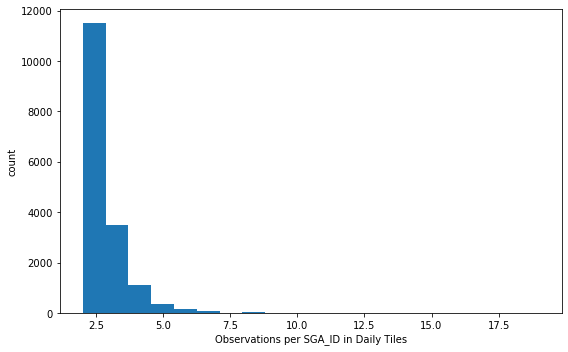

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

ax.hist(_counts_all[_counts_all > 1], bins = 20)

ax.set(xlabel='Observations per SGA_ID in Daily Tiles', 
       ylabel='count');

In [11]:
# All targets with decent redshifts and observations suitable for the Tully-Fisher analysis
tmain_tf = clean_catalog(tdaily)
_ids_goodz, _counts_goodz = np.unique(tmain_tf['SGA_ID'], return_counts=True)
_ids_goodz[_counts_goodz > 1]

  0%|          | 0/14293 [00:00<?, ?it/s]

55
117
223
581
731
1135
1158
1287
1289
1358
1663


In [12]:
tmain_goodz = np.in1d(tmain_tf['SGA_ID'], _ids_goodz[_counts_goodz > 1])
tmain_g = tmain_tf[tmain_goodz]
tmain_g

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64
2389570544992261,199.730072385194,1.72783181582658,24243,20220423,0.0437435626710041,2.3020377661851e-05,0,48.0715520321392,daily/tiles/cumulative/24243/20220423/redrock-5-24243-thru20220423.fits,TFT,55,199.73007238519418,1.7278318158265755
2389570544992261,199.730072385194,1.72783181582658,25837,20220430,0.043713446980999,2.98109984300264e-05,0,36.9368270919658,daily/tiles/cumulative/25837/20220430/redrock-3-25837-thru20220430.fits,TFT,55,199.73007238519418,1.7278318158265755
2389570544992262,199.731168566683,1.72471420712763,22682,20220508,0.0442277198032649,4.91740023312067e-06,0,1010.09990862012,daily/tiles/cumulative/22682/20220508/redrock-8-22682-thru20220508.fits,TFT,55,199.7311685666833,1.7247142071276316
39627830354515481,199.730620476388,1.72627301155604,21127,20210605,0.0439989254838724,1.09173725646285e-05,0,285.64377264207,daily/tiles/cumulative/21127/20210605/zbest-0-21127-thru20210605.fits,TFT,55,199.73062047638814,1.7262730115560398
2389593684967425,138.936887947814,2.69359099571864,26214,20220305,0.0894203282762809,1.03257031947133e-05,0,299.505344927311,daily/tiles/cumulative/26214/20220305/redrock-0-26214-thru20220305.fits,TFT,117,138.9368879478137,2.6935909957186372
39627853494489271,138.935401881933,2.69476220880469,23090,20220112,0.0900412948562097,2.87560583699443e-05,0,884.744120200397,daily/tiles/cumulative/23090/20220112/redrock-6-23090-thru20220112.fits,TFT,117,138.9354018819327,2.69476220880469
2390308285317127,197.788671878468,34.1699112536563,24300,20220221,0.0342437776882019,1.24252670967763e-05,0,114.676442600787,daily/tiles/cumulative/24300/20220221/redrock-2-24300-thru20220221.fits,TFT,223,197.78867187846762,34.16991125365625
39632966141349468,197.787014056547,34.171253677203,25870,20220107,0.0340258986446975,7.92210227932365e-06,0,573.508448885899,daily/tiles/cumulative/25870/20220107/redrock-3-25870-thru20220107.fits,TFT,223,197.78701405654667,34.171253677203055
2389978080346113,118.856456640878,18.9760695714997,22955,20211226,0.0428118152378448,2.35624567778664e-05,0,69.9700332144275,daily/tiles/cumulative/22955/20211226/redrock-6-22955-thru20211226.fits,TFT,581,118.85645664087838,18.97606957149971


#### Inclination Cut

In [17]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [14]:
SGA_main = join(tmain_g, SGA, keys_left='SGA_ID', keys_right='SGA_ID')

In [15]:
SGA_main.group_by('SGA_ID_1')

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2389570544992261,199.730072385194,1.72783181582658,24243,20220423,0.0437435626710041,2.3020377661851e-05,0,48.0715520321392,daily/tiles/cumulative/24243/20220423/redrock-5-24243-thru20220423.fits,TFT,55,199.73007238519418,1.7278318158265755,55,SGA-2020 55,PGC1203947,1203947,199.73061299999998,1.7263548999999998,S?,159.49,0.35156044,0.510505,0.04396308,24.60848,18.25,False,LEDA-20181114,17,PGC1203947,1,True,199.73061299999998,1.7263548999999998,0.35156044,1996p017,199.73062047638814,1.7262730115560398,0.4956815,SB26,160.63597,0.511194,199.7305377211278,1.7262556303464236,10.683119,7.5134478,7.237519,7.358609,1.0663536,2.4361885,4.5284705,6.209374,7.894941,9.662576,11.338187,13.058548,14.870445,21.586454,21.022594,20.5186,20.022512,19.486275,19.047207,19.079992,18.56653,18.196766,18.698801,18.197613,17.858175,18.461773,17.962809,17.637083,18.290697,17.804535,17.48882,18.184755,17.702862,17.391363,18.108042,17.630135,17.322704,18.062273,17.58211,17.270563,0.021755822,0.038157243,0.04157986,0.08506337,0.09445482,0.12531056,0.13733958,0.123995595,0.12832229,0.04457232,0.04439948,0.07058882,0.025476964,0.026438117,0.038408875,0.019658687,0.02046595,0.025474863,0.017983157,0.018753268,0.022374356,0.017475583,0.01794357,0.02073173,0.01711202,0.017407436,0.019818878,0.0165

In [16]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

q0 = 0.2

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

SGA_main['cosi'] = np.sqrt((SGA_main['BA']**2 - q0**2)/(1 - q0**2))
SGA_main['cosi'][np.isnan(SGA_main['BA'])] = 0 # Objects with b/a < 0.2

/tmp/ipykernel_52421/3867589514.py:14: RuntimeWarning: invalid value encountered in sqrt
  SGA_main['cosi'] = np.sqrt((SGA_main['BA']**2 - q0**2)/(1 - q0**2))


In [18]:
for col in SGA_main.colnames:
    SGA_main = SGA_main[SGA_main['cosi'] < cosi_max]

In [19]:
SGA_main

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
2389570544992261,199.730072385194,1.72783181582658,24243,20220423,0.0437435626710041,2.3020377661851e-05,0,48.0715520321392,daily/tiles/cumulative/24243/20220423/redrock-5-24243-thru20220423.fits,TFT,55,199.73007238519418,1.7278318158265755,55,SGA-2020 55,PGC1203947,1203947,199.73061299999998,1.7263548999999998,S?,159.49,0.35156044,0.510505,0.04396308,24.60848,18.25,False,LEDA-20181114,17,PGC1203947,1,True,199.73061299999998,1.7263548999999998,0.35156044,1996p017,199.73062047638814,1.7262730115560398,0.4956815,SB26,160.63597,0.511194,199.7305377211278,1.7262556303464236,10.683119,7.5134478,7.237519,7.358609,1.0663536,2.4361885,4.5284705,6.209374,7.894941,9.662576,11.338187,13.058548,14.870445,21.586454,21.022594,20.5186,20.022512,19.486275,19.047207,19.079992,18.56653,18.196766,18.698801,18.197613,17.858175,18.461773,17.962809,17.637083,18.290697,17.804535,17.48882,18.184755,17.702862,17.391363,18.108042,17.630135,17.322704,18.062273,17.58211,17.270563,0.021755822,0.038157243,0.04157986,0.08506337,0.09445482,0.12531056,0.13733958,0.123995595,0.12832229,0.04457232,0.04439948,0.07058882,0.025476964,0.026438117,0.038408875,0.019658687,0.02046595,0.025474863,0.017983157,0.018753268,0.022374356,0.017475583,0.01794357,0.02073173,0.01711202,0.017407436,0.019

#### Morphology Cut

for col in SGA_main.colnames:
    SGA_main = SGA_main[SGA_main['MORPHTYPE'].startswith('S')]

In [26]:
for j in range(0,20): 
    for i in range(0, len(SGA_main)):
        morphtype = str(SGA_main['MORPHTYPE'][i])
    
        # Cut any suspected ellipticals
        if morphtype.startswith('S'):
            continue
        
    #print(i, morphtype)
    
        SGA_main.remove_row(i)

In [27]:
# All targets
_ids_all, _counts_all = np.unique(SGA_main['SGA_ID_1'], return_counts=True)
_ids_all[_counts_all > 1]

55
117
223
581
731
1158
1287
1289
1358
1663
1849


## Clusters

In [26]:
hdu = fits.open('/global/homes/r/rehrenre/DESI_SGA/TF/Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

#[:100]

In [28]:
hdu = fits.open('/global/homes/r/rehrenre/DESI_SGA/TF/Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

#table2[:10]

### Abell 2151

In [29]:
a2151_nest = 100007

a2151_row_t3 = table3['Nest'] == a2151_nest

R2t_a2151 = table3['R2t'][a2151_row_t3][0]
sigma_a2151 = table3['sigP'][a2151_row_t3][0]

In [215]:
a2151_coords = SkyCoord(table3['SGLON'][a2151_row_t3]*u.degree, 
                       table3['SGLAT'][a2151_row_t3]*u.degree, 
                       frame='supergalactic')

a2151_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = a2151_coords.match_to_catalog_sky(a2151_group_coords)

V_a2151 = table2['__HV_'][idx][0]

In [216]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_a2151_angle = (R2t_a2151/(V_a2151/H0))*u.radian

In [217]:
a2151_tf_coords = SkyCoord(SGA_main['TARGET_RA'], SGA_main['TARGET_DEC'], unit='deg')

a21sep = a2151_coords.separation(a2151_tf_coords)

In [218]:
fuji_in_a21511 = (a21sep < 1.5*R2t_a2151_angle) & (SGA_main['Z']*c > V_a2151 - 3*sigma_a2151) & (SGA_main['Z']*c < V_a2151 + 3*sigma_a2151)

fuji_in_a21512 = (a21sep >= 1.5*R2t_a2151_angle) & (a21sep < 3*R2t_a2151_angle) & (SGA_main['Z']*c > V_a2151 - 2*sigma_a2151) & (SGA_main['Z']*c < V_a2151 + 2*sigma_a2151)

fuji_in_a2151 = fuji_in_a21511 | fuji_in_a21512

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
fuji_ID_in_a2151 = np.unique(SGA_main['SGA_ID_1'][fuji_in_a2151])

idx_fuji_in_a2151 = np.in1d(SGA_main['SGA_ID_1'], fuji_ID_in_a2151)

inAbell2151_fuji_table = SGA_main[idx_fuji_in_a2151]
################################################################################

inAbell2151_fuji_table

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
2403104976797696,242.237193981712,16.076340890689,1248,20210604,0.0446933683092703,1.8615322917475e-05,0,52.2669379748404,daily/tiles/cumulative/1248/20210604/zbest-0-1248-thru20210604.fits,TFT,199506,242.2371939817116,16.076340890688957,199506,SGA-2020 199506,PGC1500169,1500169,242.23924499999995,16.0772147,S?,69.49,0.3404082,0.5508077,0.044333335,24.15448,17.866,False,LEDA-20181114,71702,PGC1500169,1,True,242.23924499999995,16.0772147,0.3404082,2422p160,242.23922930683972,16.07718564249266,0.63911074,SB26,66.638954,0.5826514,242.23902338166434,16.07731911409317,12.546541,9.233577,9.072024,8.995666,1.2114037,2.9057207,5.3967147,7.527639,9.821191,12.089841,14.330175,16.6913,19.173323,21.256048,20.559961,20.184645,19.692987,19.017784,18.6041,18.734299,18.10207,17.693335,18.280859,17.67721,17.275787,17.991032,17.40173,17.017763,17.815247,17.236809,16.85324,17.694616,17.12555,16.741102,17.604082,17.037941,16.657568,17.54223,16.979681,16.611195,0.01547525,0.034365803,0.058886744,0.070501305,0.10553768,0.16224873,0.11997011,0.17204884,0.21107358,0.04611504,0.053133156,0.046881173,0.017104572,0.02003206,0.019869734,0.0115416525,0.01333,0.014103756,0.0119157,0.012673238,0.012745979,0.012048899,0.012350355,0.0123492135,0.0118042845,0.0119444225,0.012110343,0.

Text(0, 0.5, 'Count')

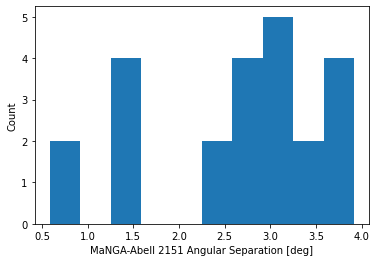

In [219]:
plt.hist(a21sep[fuji_in_a2151].to_value('degree'))
plt.xlabel('MaNGA-Abell 2151 Angular Separation [deg]')
plt.ylabel('Count')

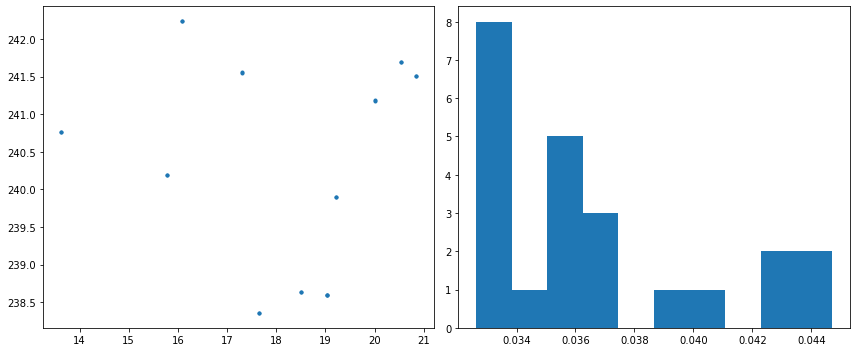

In [220]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)
ax = axes[0]
ax.plot(inAbell2151_fuji_table['TARGET_DEC'], inAbell2151_fuji_table['TARGET_RA'], '.')
ax = axes[1]
ax.hist(inAbell2151_fuji_table['Z']);

#### Multiple counts

In [221]:
ids, counts = np.unique(inAbell2151_fuji_table['SGA_ID_1'], return_counts=True)
ids[counts > 1]

199506
378878
447873
451135
472833
485824
547663
826297
951262
1190077
1354164


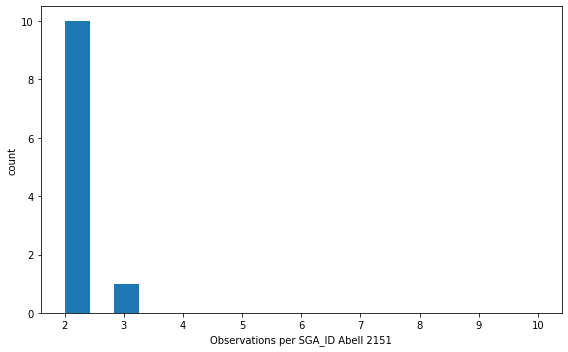

In [222]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

ax.hist(counts[counts > 1], bins=np.linspace(2,10,20))

ax.set(xlabel='Observations per SGA_ID Abell 2151', 
       ylabel='count');

In [223]:
# Keep only those with more than one observation
high_count_sga = np.in1d(inAbell2151_fuji_table['SGA_ID_1'], ids[counts > 1])
tf_a2151_multiple = inAbell2151_fuji_table[high_count_sga]
tf_a2151_multiple

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
2403104976797696,242.237193981712,16.076340890689,1248,20210604,0.0446933683092703,1.8615322917475e-05,0,52.2669379748404,daily/tiles/cumulative/1248/20210604/zbest-0-1248-thru20210604.fits,TFT,199506,242.2371939817116,16.076340890688957,199506,SGA-2020 199506,PGC1500169,1500169,242.23924499999995,16.0772147,S?,69.49,0.3404082,0.5508077,0.044333335,24.15448,17.866,False,LEDA-20181114,71702,PGC1500169,1,True,242.23924499999995,16.0772147,0.3404082,2422p160,242.23922930683972,16.07718564249266,0.63911074,SB26,66.638954,0.5826514,242.23902338166434,16.07731911409317,12.546541,9.233577,9.072024,8.995666,1.2114037,2.9057207,5.3967147,7.527639,9.821191,12.089841,14.330175,16.6913,19.173323,21.256048,20.559961,20.184645,19.692987,19.017784,18.6041,18.734299,18.10207,17.693335,18.280859,17.67721,17.275787,17.991032,17.40173,17.017763,17.815247,17.236809,16.85324,17.694616,17.12555,16.741102,17.604082,17.037941,16.657568,17.54223,16.979681,16.611195,0.01547525,0.034365803,0.058886744,0.070501305,0.10553768,0.16224873,0.11997011,0.17204884,0.21107358,0.04611504,0.053133156,0.046881173,0.017104572,0.02003206,0.019869734,0.0115416525,0.01333,0.014103756,0.0119157,0.012673238,0.012745979,0.012048899,0.012350355,0.0123492135,0.0118042845,0.0119444225,0.012110343,0.

#### Calculate Rotational Velocities

In [224]:
sga_ids_vel_cuts = []
R26 = []
rmag = []
drmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inAbell2151_fuji_table['SGA_ID_1'])):
    # if sga_id == 474614:
    #     print('skipped')
    #     continue
    galaxy_list = inAbell2151_fuji_table[inAbell2151_fuji_table['SGA_ID_1'] == sga_id]
    # print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    # print(good_vel[0], sga_id)
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))
            
            R26.append(0.5 * sga_galaxy['D26']*u.arcmin)
            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            drmag.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax.append(v033)
            dvmax.append(dv033)
            sga_ids_vel_cuts.append(sga_id)
    # break
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

10


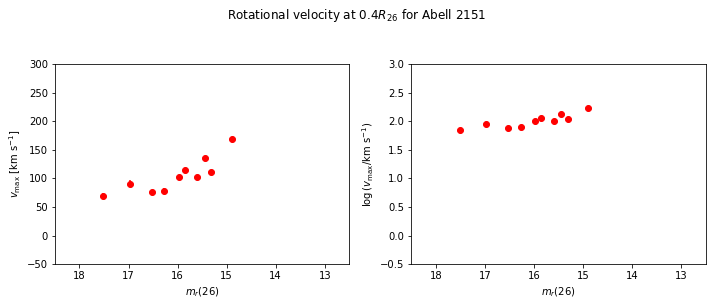

In [225]:
rmag = np.asarray(rmag)
drmag = np.asarray(drmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)
R26 = np.asarray(R26)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], xerr=drmag[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.4R_{26}$ for Abell 2151', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

In [226]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

inAbell2151_fuji_table['cosi'] = np.sqrt((inAbell2151_fuji_table['BA']**2 - q0**2)/(1 - q0**2))
inAbell2151_fuji_table['cosi'][np.isnan(inAbell2151_fuji_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

# for sga_id in np.unique(inComa_sga_table['SGA_ID']):
for sga_id in sga_ids_vel_cuts:
    galaxy_list = inAbell2151_fuji_table[inAbell2151_fuji_table['SGA_ID_1'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)
            z.append(zc)
            rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            drmag_clean.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            sga_ids_clean.append(sga_id)
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

11


In [227]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def l2norm(pars, x, y, dy):
    '''
    Linear fit that uses the l2-norm
    '''
    a, b = pars
    return np.sum((y - a - b*x)**2/dy**2)

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = 6, -0.25
    hess_inv = np.ones((2,2))
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(1000):
        _a, _b = np.random.uniform(0,10), np.random.uniform(-1,0)
        
        res = minimize(l1norm_noerror, 
                       [_a, _b], 
                       args=(r, logv),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[0,10], [-1,1]])
        
        if res.fun < fmin and res.success:
            print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
    
    if succ_res is None:
        print('No successful fits')
    else:
        print(succ_res)
    
    return a, b, hess_inv

Original
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 0.49225350355838193, 'jac': array([0.        , 7.69017344]), 'nfev': 747, 'njev': 249, 'nit': 44, 'status': 0, 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 3.73132387, -0.10792904]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
3.731323872614582 -0.10792903788574526


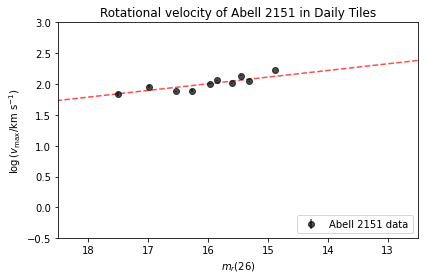

In [228]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.7,
            label='Abell 2151 data')

a, b, _ = fit_tfr(rmag[isrmeas], log10vmax[isrmeas], dlog10vmax[isrmeas])
print(a, b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.7)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
'''
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, _ = fit_tfr(rmag_clean[isrmeas_clean], 
                  log10vmax_clean[isrmeas_clean], 
                  dlog10vmax_clean[isrmeas_clean])
print(a, b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
'''
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity of Abell 2151 in Daily Tiles')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

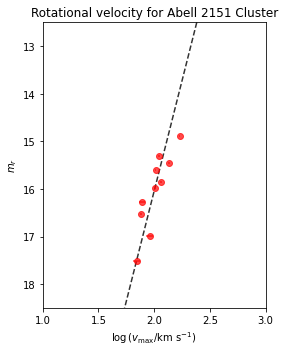

In [229]:
fig, ax = plt.subplots(1,1, figsize=(4,5), tight_layout=True)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

r = np.arange(12.5,18.6,0.1)
v = a + b*r

################################################################################
# Compute and plot the uncertainty range around the best fit
#-------------------------------------------------------------------------------
'''
hessian = ndt.Hessian(l1norm)
hess = hessian((a,b), 
               rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])

N_samples = 1000

random_samples = np.random.multivariate_normal(mean=(a,b), 
                                               cov=np.linalg.inv(np.abs(hess)), #hess_inv.matmat(np.eye(2)), 
                                               size=N_samples)

y_samples = np.zeros([1000, len(r)])
for i in range(len(r)):
    y_samples[:,i] = random_samples[:,0] + random_samples[:,1]*r[i]

std_dev = np.std(y_samples, axis=0)

ax.fill_betweenx(r, v-std_dev, v+std_dev, facecolor='lightgray')
'''
################################################################################

ax.plot(v, r, 'k--', alpha=0.8)

ax.errorbar(log10vmax[isrmeas], 
            rmag[isrmeas], 
            xerr=dlog10vmax[isrmeas], 
            fmt='ro', 
            alpha=0.7)

ax.set(ylabel='$m_r$',
       ylim=(18.5, 12.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(1,3),
       title='Rotational velocity for Abell 2151 Cluster');

#plt.savefig('../Figures/PV_TFR_Coma_fitWOerrors_09262021.eps', format='eps', dpi=120);

In [230]:
len(log10vmax[isrmeas])

10

#### Hyperfit

In [231]:
# Create a 2x2xN matrix.
ndata = len(dlog10vmax[isrmeas])
cov = np.empty((2, 2, ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i, (dlogv, dm) in enumerate(zip(dlog10vmax[isrmeas], drmag[isrmeas])):
    cov[:,:,i] = np.array([[dlogv**2, 0.], [0., dm**2]])
                              
# cov[:,:,0]

In [232]:
logv = log10vmax[isrmeas]
mr = rmag[isrmeas]
logv.shape, mr.shape

((10,), (10,))

In [233]:
data1 = [logv, mr]
cov1 = cov

In [234]:
hf = LinFit([logv, mr], cov)

In [235]:
# Run an MCMC
bounds = ((-10.0, 10.0), (-1000.0, 1000.0), (1.0e-5, 500.0))
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

# # Make the plot
# data.plot(linfit=hf)

     fun: array([-23.9978136])
     jac: array([0.00035243, 0.00063238, 0.00106155])
 message: 'Optimization terminated successfully.'
    nfev: 4581
     nit: 100
 success: True
       x: array([4.08214223, 0.54730503, 0.05185157])


100%|██████████| 1000/1000 [00:00<00:00, 1022.60it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [74.24226033 73.81325588 35.79444739] / 3712.1130162667514


100%|██████████| 1000/1000 [00:00<00:00, 1002.12it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [95.32507055 93.90873241 43.80946828] / 4766.253527472632


100%|██████████| 1000/1000 [00:01<00:00, 975.69it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [108.9799648  109.15177342  57.99583517] / 5457.588670817304


100%|██████████| 1000/1000 [00:01<00:00, 970.94it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [107.07783776 104.71039786  57.24373671] / 5353.89188800418


100%|██████████| 1000/1000 [00:01<00:00, 970.45it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.73619045 146.60569737  83.31291844] / 7386.809522619425


100%|██████████| 1000/1000 [00:00<00:00, 1032.24it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [138.01685272 138.16404224  73.17438452] / 6908.202112186231


100%|██████████| 1000/1000 [00:00<00:00, 1017.12it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [155.17728139 153.40692269  87.81083185] / 7758.864069610147


100%|██████████| 1000/1000 [00:00<00:00, 1064.47it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.97572877 146.81990432  99.35710752] / 7498.78643830876


100%|██████████| 1000/1000 [00:01<00:00, 995.80it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [176.81777305 178.55090632 105.38313922] / 8927.545315900394


100%|██████████| 1000/1000 [00:00<00:00, 1039.05it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [198.36725177 194.83928742  85.91499763] / 9918.36258844055


100%|██████████| 1000/1000 [00:00<00:00, 1025.90it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [193.0243871  187.69463424  71.48901466] / 9651.219354832168


100%|██████████| 1000/1000 [00:00<00:00, 1038.15it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [193.90570853 189.9520455   71.112948  ] / 9695.285426647277
[-7.69514558 31.47423351  0.5537819 ] [2.26414663 4.56037065 0.29078173]


In [236]:
a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -7.70 +/- 2.26
 31.47 +/- 4.56
  0.55 +/- 0.29


In [18]:
sigmas = hf.get_sigmas()
xvals = np.linspace(0., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [log10vmax[isrmeas], rmag[isrmeas]]
x_err = dlog10vmax[isrmeas]
y_err = drmag[isrmeas]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2.0 * y_err[i],
        height=2.0 * x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig = plt.figure(figsize=(6,7))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(cmo.cm.haline(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    e.set_alpha(1)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.15)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=1)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=1)
ax.set_xlabel(r"$\log_{10}{(v_\mathrm{0.4R_{26}} / \mathrm{km~s^{-1}})}$", fontsize=16)
ax.set_ylabel(r"$m_r$", fontsize=16)
ax.set_title(r"Abell 2151", fontsize=16)
ax.set_xlim(1.25, 2.75)
ax.set_ylim(18, 14.5)

# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmo.cm.haline),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)

NameError: name 'hf' is not defined

In [57]:
import cmocean as cmo

In [238]:
sigmas1 = hf.get_sigmas()

In [239]:
vert1 = hf.vert_scat

In [59]:
import corner

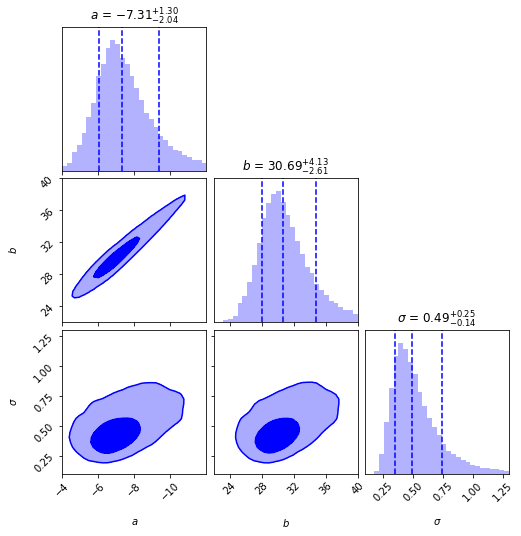

In [60]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
             range=[[-4, -12], [22, 40], [0.1, 1.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

### Virgo

In [151]:
virgo_nest = 100002

virgo_row_t3 = table3['Nest'] == virgo_nest

R2t_virgo = table3['R2t'][virgo_row_t3][0]
sigma_virgo = table3['sigP'][virgo_row_t3][0]

In [152]:
virgo_coords = SkyCoord(table3['SGLON'][virgo_row_t3]*u.degree, 
                       table3['SGLAT'][virgo_row_t3]*u.degree, 
                       frame='supergalactic')

v_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = virgo_coords.match_to_catalog_sky(v_group_coords)

V_virgo = table2['__HV_'][idx][0]

In [153]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_virgo_angle = (R2t_virgo/(V_virgo/H0))*u.radian

In [154]:
v_tf_coords = SkyCoord(SGA_main['TARGET_RA'], SGA_main['TARGET_DEC'], unit='deg')

vsep = virgo_coords.separation(v_tf_coords)

In [155]:
fuji_in_virgo1 = (vsep < 1.5*R2t_virgo_angle) & (SGA_main['Z']*c > V_virgo - 3*sigma_virgo) & (SGA_main['Z']*c < V_virgo + 3*sigma_virgo)

fuji_in_virgo2 = (vsep >= 1.5*R2t_virgo_angle) & (vsep < 3*R2t_virgo_angle) & (SGA_main['Z']*c > V_virgo - 2*sigma_virgo) & (SGA_main['Z']*c < V_virgo + 2*sigma_virgo)

fuji_in_virgo = fuji_in_virgo1 | fuji_in_virgo2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
fuji_ID_in_virgo = np.unique(SGA_main['SGA_ID_1'][fuji_in_virgo])

idx_fuji_in_virgo = np.in1d(SGA_main['SGA_ID_1'], fuji_ID_in_virgo)

inVirgo_fuji_table = SGA_main[idx_fuji_in_virgo]
################################################################################

inVirgo_fuji_table

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
39627890546968314,189.603744095967,4.32561544418394,25825,20220213,0.00297182105273451,2.00635001395342e-06,0,4845.31656556251,daily/tiles/cumulative/25825/20220213/redrock-4-25825-thru20220213.fits,EXT,14524,189.60376460534334,4.3258305977988645,14524,SGA-2020 14524,NGC4586,42241,189.618414,4.319094000000001,Sa,115.52,3.4276776,0.32658783,0.002612474,23.83448,12.531,False,LEDA-20181114,3888,NGC4586,1,True,189.618414,4.319094000000001,3.4276776,1896p042,189.6182344244714,4.318980091400209,9.5834055,SB25,115.398186,0.32161033,189.61856697321682,4.319076765341496,132.21805,95.137924,88.875854,81.17043,69.81917,101.737465,134.5221,164.50415,189.84145,210.28648,230.00174,247.45894,-1.0,12.719163,11.838446,11.118479,12.346305,11.494747,10.806508,12.071596,11.235313,10.565324,11.886447,11.059812,10.401434,11.794314,10.975497,10.329725,11.739744,10.929104,10.291979,11.708932,10.90216,10.269288,11.689381,10.884753,10.254391,-1.0,-1.0,-1.0,0.41359407,0.541912,0.38884482,0.46940157,0.27970782,0.44574907,0.49303272,0.5412784,-1.0,0.0057877395,0.007306858,0.011079659,0.0042836484,0.00544983,0.0083844885,0.0034322059,0.0043678437,0.0067617283,0.0029568523,0.0037622754,0.0058421474,0.0027404686,0.0034980432,0.0054753646,0.0026183617,0.0033592815,0.0052917353,0.0025

Text(0, 0.5, 'Count')

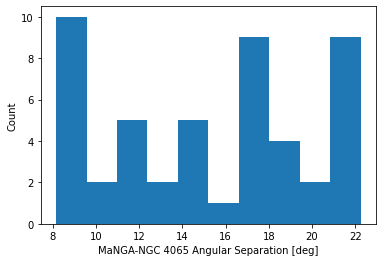

In [156]:
plt.hist(vsep[fuji_in_virgo].to_value('degree'))
plt.xlabel('MaNGA-NGC 4065 Angular Separation [deg]')
plt.ylabel('Count')

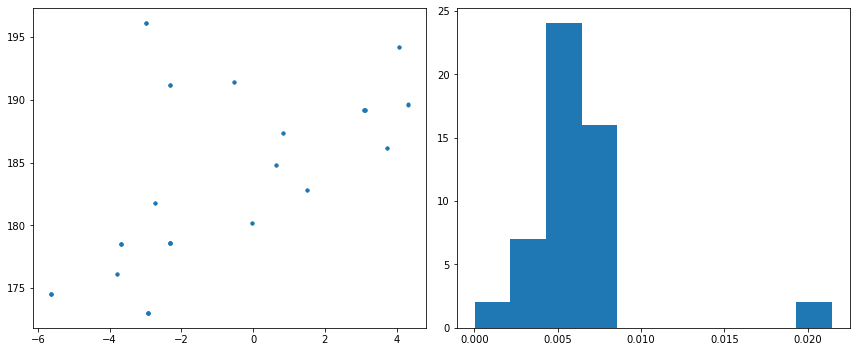

In [157]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)
ax = axes[0]
ax.plot(inVirgo_fuji_table['TARGET_DEC'], inVirgo_fuji_table['TARGET_RA'], '.')
ax = axes[1]
ax.hist(inVirgo_fuji_table['Z']);

#### Multiple Counts

In [158]:
ids, counts = np.unique(inVirgo_fuji_table['SGA_ID_1'], return_counts=True)
ids[counts > 1]

14524
149009
200990
293906
389366
638386
698806
752047
897339
960953
964838


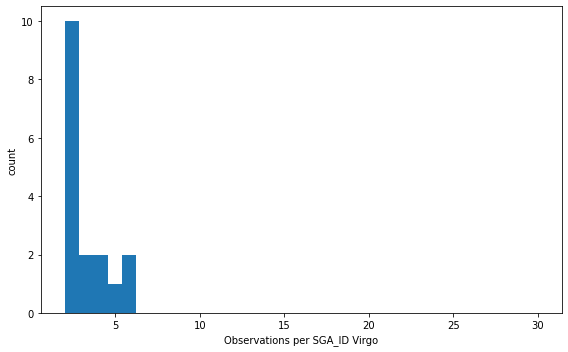

In [159]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

ax.hist(counts[counts > 1], bins=np.linspace(2,30,34))

ax.set(xlabel='Observations per SGA_ID Virgo', 
       ylabel='count');

In [160]:
# Keep only those with more than one observation
high_count_sga = np.in1d(inVirgo_fuji_table['SGA_ID_1'], ids[counts > 1])
tf_virgo_multiple = inVirgo_fuji_table[high_count_sga]
tf_virgo_multiple

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,cosi
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32
39627890546968314,189.603744095967,4.32561544418394,25825,20220213,0.00297182105273451,2.00635001395342e-06,0,4845.31656556251,daily/tiles/cumulative/25825/20220213/redrock-4-25825-thru20220213.fits,EXT,14524,189.60376460534334,4.3258305977988645,14524,SGA-2020 14524,NGC4586,42241,189.618414,4.319094000000001,Sa,115.52,3.4276776,0.32658783,0.002612474,23.83448,12.531,False,LEDA-20181114,3888,NGC4586,1,True,189.618414,4.319094000000001,3.4276776,1896p042,189.6182344244714,4.318980091400209,9.5834055,SB25,115.398186,0.32161033,189.61856697321682,4.319076765341496,132.21805,95.137924,88.875854,81.17043,69.81917,101.737465,134.5221,164.50415,189.84145,210.28648,230.00174,247.45894,-1.0,12.719163,11.838446,11.118479,12.346305,11.494747,10.806508,12.071596,11.235313,10.565324,11.886447,11.059812,10.401434,11.794314,10.975497,10.329725,11.739744,10.929104,10.291979,11.708932,10.90216,10.269288,11.689381,10.884753,10.254391,-1.0,-1.0,-1.0,0.41359407,0.541912,0.38884482,0.46940157,0.27970782,0.44574907,0.49303272,0.5412784,-1.0,0.0057877395,0.007306858,0.011079659,0.0042836484,0.00544983,0.0083844885,0.0034322059,0.0043678437,0.0067617283,0.0029568523,0.0037622754,0.0058421474,0.0027404686,0.0034980432,0.0054753646,0.0026183617,0.0033592815,0.0052917353,0.0025

#### Rotational Velocities

In [161]:
sga_ids_vel_cuts = []

rmag = []
drmag = []
vmax = []
dvmax = []

for i, sga_id in enumerate(np.unique(inVirgo_fuji_table['SGA_ID_1'])):
    # if sga_id == 474614:
    #     print('skipped')
    #     continue
    galaxy_list = inVirgo_fuji_table[inVirgo_fuji_table['SGA_ID_1'] == sga_id]
    # print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    # print(good_vel[0], sga_id)
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26']))
            drmag.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax.append(v033)
            dvmax.append(dv033)
            sga_ids_vel_cuts.append(sga_id)
    # break
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

14


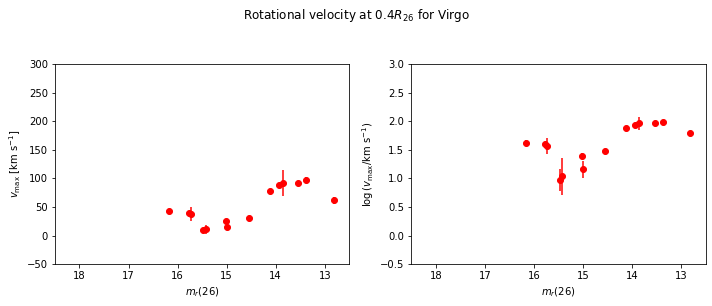

In [162]:
rmag = np.asarray(rmag)
drmag = np.asarray(drmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], xerr=drmag[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.4R_{26}$ for Virgo', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

In [163]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

inVirgo_fuji_table['cosi'] = np.sqrt((inVirgo_fuji_table['BA']**2 - q0**2)/(1 - q0**2))
inVirgo_fuji_table['cosi'][np.isnan(inVirgo_fuji_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

# for sga_id in np.unique(inComa_sga_table['SGA_ID']):
for sga_id in sga_ids_vel_cuts:
    galaxy_list = inVirgo_fuji_table[inVirgo_fuji_table['SGA_ID_1'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)
            z.append(zc)
            rmag_clean.append(float(sga_galaxy['R_MAG_SB26']))
            drmag_clean.append(float(sga_galaxy['R_MAG_SB26_ERR']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            sga_ids_clean.append(sga_id)
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

14


Original
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
Successful fit
{'fun': 2.9746141680214513, 'jac': array([-0.14314114, -1.58738458]), 'nfev': 615, 'njev': 205, 'nit': 27, 'status': 0, 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'x': array([ 4.32633012, -0.1750108 ]), 'success': True, 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>}
4.326330122773627 -0.175010798792513


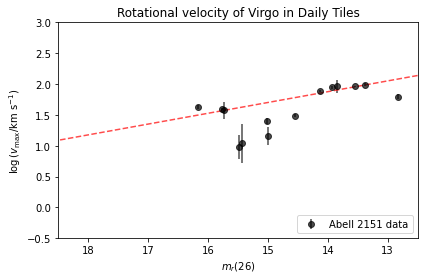

In [164]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
print('Original')

ax.errorbar(rmag[isrmeas], 
            log10vmax[isrmeas], 
            yerr=dlog10vmax[isrmeas], 
            fmt='ko', 
            alpha=0.7,
            label='Abell 2151 data')

a, b, _ = fit_tfr(rmag[isrmeas], log10vmax[isrmeas], dlog10vmax[isrmeas])
print(a, b)

r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.7)
################################################################################


################################################################################
# Cleaned data
#-------------------------------------------------------------------------------
'''
print('\nCleaned')

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

ax.errorbar(rmag_clean[isrmeas_clean], 
            log10vmax_clean[isrmeas_clean], 
            yerr=dlog10vmax_clean[isrmeas_clean], 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

a, b, _ = fit_tfr(rmag_clean[isrmeas_clean], 
                  log10vmax_clean[isrmeas_clean], 
                  dlog10vmax_clean[isrmeas_clean])
print(a, b)
r = np.arange(12.5,18.6,0.1)
ax.plot(r, a + b*r, 'r--', alpha=0.8)
'''
################################################################################


ax.set(xlabel='$m_r$(26)',
       xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3),
       title=r'Rotational velocity of Virgo in Daily Tiles')

ax.legend(loc='lower right', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_coma.png', dpi=120)

# print(np.sum(isrmeas))

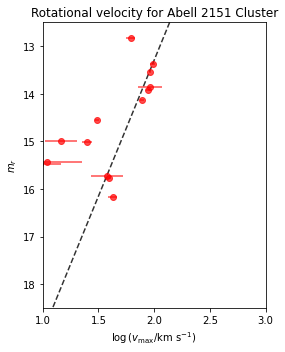

In [165]:
fig, ax = plt.subplots(1,1, figsize=(4,5), tight_layout=True)

rmag_clean = np.asarray(rmag_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

isrmeas_clean = rmag_clean > 0

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean

r = np.arange(12.5,18.6,0.1)
v = a + b*r

################################################################################
# Compute and plot the uncertainty range around the best fit
#-------------------------------------------------------------------------------
'''
hessian = ndt.Hessian(l1norm)
hess = hessian((a,b), 
               rmag_clean[isrmeas_clean], 
               log10vmax_clean[isrmeas_clean], 
               dlog10vmax_clean[isrmeas_clean])

N_samples = 1000

random_samples = np.random.multivariate_normal(mean=(a,b), 
                                               cov=np.linalg.inv(np.abs(hess)), #hess_inv.matmat(np.eye(2)), 
                                               size=N_samples)

y_samples = np.zeros([1000, len(r)])
for i in range(len(r)):
    y_samples[:,i] = random_samples[:,0] + random_samples[:,1]*r[i]

std_dev = np.std(y_samples, axis=0)

ax.fill_betweenx(r, v-std_dev, v+std_dev, facecolor='lightgray')
'''
################################################################################

ax.plot(v, r, 'k--', alpha=0.8)

ax.errorbar(log10vmax[isrmeas], 
            rmag[isrmeas], 
            xerr=dlog10vmax[isrmeas], 
            fmt='ro', 
            alpha=0.7)

ax.set(ylabel='$m_r$',
       ylim=(18.5, 12.5),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       xlim=(1,3),
       title='Rotational velocity for Abell 2151 Cluster');

#plt.savefig('../Figures/PV_TFR_Coma_fitWOerrors_09262021.eps', format='eps', dpi=120);

In [166]:
len(log10vmax[isrmeas])

14

#### Hyperfit

In [167]:
# Create a 2x2xN matrix.
ndata = len(dlog10vmax[isrmeas])
cov = np.empty((2, 2, ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i, (dlogv, dm) in enumerate(zip(dlog10vmax[isrmeas], drmag[isrmeas])):
    cov[:,:,i] = np.array([[dlogv**2, 0.], [0., dm**2]])
                              
# cov[:,:,0]

In [168]:
logv = log10vmax[isrmeas]
mr = rmag[isrmeas]
logv.shape, mr.shape

((14,), (14,))

In [169]:
data2 = [logv, mr]
cov2 = cov

In [170]:
hf = LinFit([logv, mr], cov)

In [171]:
hf

In [179]:
# Run an MCMC
bounds = ((-6.0, 6.0), (-1000.0, 1000.0), (1.0e-5, 500.0))
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

# # Make the plot
# data.plot(linfit=hf)

     fun: array([-13.58789583])
     jac: array([ 0.00060894, -0.00203855,  0.00287237])
 message: 'Optimization terminated successfully.'
    nfev: 4422
     nit: 97
 success: True
       x: array([4.33844506, 0.84809931, 0.19091661])


100%|██████████| 1000/1000 [00:00<00:00, 1042.89it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.60068537 77.1046553  40.19267433] / 3930.034268693189


100%|██████████| 1000/1000 [00:00<00:00, 1037.23it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [99.26084072 99.32101223 56.22287749] / 4966.050611623796


100%|██████████| 1000/1000 [00:00<00:00, 1005.41it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [177.28476001 172.44736925  70.15387915] / 8864.238000441459


100%|██████████| 1000/1000 [00:00<00:00, 1008.58it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [131.45796242 129.54047701  56.58691385] / 6572.898120946318


100%|██████████| 1000/1000 [00:01<00:00, 993.06it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [162.31821171 156.83655697  52.11849174] / 8115.91058538493


100%|██████████| 1000/1000 [00:00<00:00, 1016.05it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [179.48158036 177.33330559  50.86335568] / 8974.079018062577


100%|██████████| 1000/1000 [00:01<00:00, 995.72it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [153.34405794 155.81226379  55.82441998] / 7790.61318947835


100%|██████████| 1000/1000 [00:00<00:00, 1013.24it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [159.21231609 162.08118986  76.9851355 ] / 8104.059493243659


100%|██████████| 1000/1000 [00:00<00:00, 1053.09it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.68341024 155.5101245   97.15851166] / 7775.506225210383


100%|██████████| 1000/1000 [00:00<00:00, 1014.12it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [144.08522947 149.47570481 104.1090377 ] / 7473.7852407304035


100%|██████████| 1000/1000 [00:00<00:00, 1008.72it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.52411962 167.96950224  93.76140793] / 8398.475111793246


100%|██████████| 1000/1000 [00:01<00:00, 973.08it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [168.00035582 186.40993268  87.36857477] / 9320.496634105868


100%|██████████| 1000/1000 [00:00<00:00, 1001.49it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [199.19039852 217.69119884  87.42872151] / 10884.559941995325


100%|██████████| 1000/1000 [00:00<00:00, 1036.85it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [190.89323611 206.60747321  88.04314805] / 10330.373660499103


100%|██████████| 1000/1000 [00:00<00:00, 1027.89it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [196.05081982 205.30459281  93.07091733] / 10265.22964033229


100%|██████████| 1000/1000 [00:00<00:00, 1050.08it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [211.12005017 221.99133159 100.45442588] / 11099.566579661578


100%|██████████| 1000/1000 [00:00<00:00, 1034.45it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [220.35111469 228.89023953  94.55873837] / 11444.511976671733


100%|██████████| 1000/1000 [00:01<00:00, 982.97it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [216.55932683 226.56363093  92.45736059] / 11328.181546469956
[-5.13735281 23.03875715  1.28708984] [2.48808798 4.19103582 0.87655462]


In [180]:
a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -5.14 +/- 2.49
 23.04 +/- 4.19
  1.29 +/- 0.88


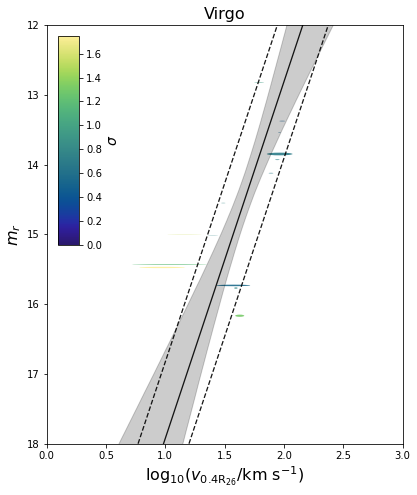

In [181]:
sigmas = hf.get_sigmas()
xvals = np.linspace(0., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [log10vmax[isrmeas], rmag[isrmeas]]
x_err = dlog10vmax[isrmeas]
y_err = drmag[isrmeas]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2.0 * y_err[i],
        height=2.0 * x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig = plt.figure(figsize=(6,7))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(cmo.cm.haline(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.set_xlabel(r"$\log_{10}{(v_\mathrm{0.4R_{26}} / \mathrm{km~s^{-1}})}$", fontsize=16)
ax.set_ylabel(r"$m_r$", fontsize=16)
ax.set_title(r"Virgo", fontsize=16)
ax.set_xlim(0, 3)
ax.set_ylim(18, 12)

# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmo.cm.haline),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)

In [305]:
sigma2 = hf.get_sigmas()

In [212]:
vert2 = hf.vert_scat

In [85]:
import cmocean

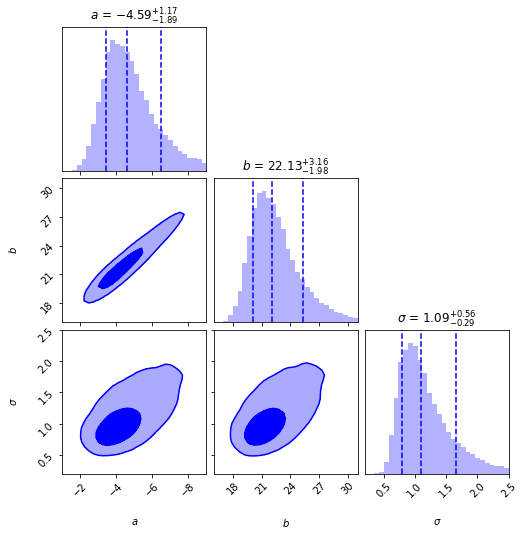

In [86]:
fig = corner.corner(mcmc_samples.T, bins=30, smooth=1,
             range=[[-1, -9], [16, 31], [0.2, 2.5]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b$', r'$\sigma$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title = {'Coma'},
             title_kwargs={"fontsize": 12})

### Abell 2151 and Virgo

#### Chi Squared

In [87]:
def chi2(params, data1, data2, cov1, cov2):
    """Chi-square function for joint slope fit to two data sets.
    
    Parameters
    ----------
    data1 : ndarray
        2xN array of [x1, y1] for data set 1.
    data2 : ndarray
        2xM array of [x2, y2] for data set 2.
    cov1 : ndarray
        2x2xN covariances for data set 1.
    cov2 : ndarray
        2x2xM covariances for data set 2.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    a, b1, b2 = params
    
    x1, y1 = data1[0], data1[1]
    varx1, vary1 = cov1[0,0], cov1[1,1]
    chi2_1 = np.sum((y1 - a*x1 - b1)**2 / (vary1 + a**2*varx1))
    
    x2, y2 = data2[0], data2[1]
    varx2, vary2 = cov2[0,0], cov2[1,1]
    chi2_2 = np.sum((y2 - a*x2 - b2)**2 / (vary2 + a**2*varx2))
    
    return chi2_1 + chi2_2



In [88]:
p0 = [-6, 31, 22]
res = minimize(chi2, p0, args=(data1, data2, cov1, cov2), method='BFGS')
res

      fun: 687.0464466868167
 hess_inv: array([[ 8.43011281e-07, -3.32799904e-06, -2.05578502e-06],
       [-3.32799904e-06,  6.30859518e-04,  5.06681536e-04],
       [-2.05578502e-06,  5.06681536e-04,  9.73802067e-04]])
      jac: array([1.20544434e-03, 4.34875488e-04, 3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 393
      nit: 16
     njev: 95
   status: 2
  success: False
        x: array([-5.73255669, 27.44898742, 24.57147585])

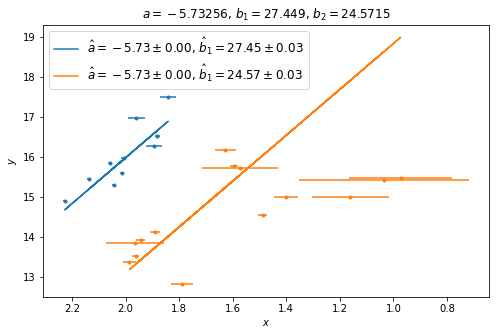

In [89]:
a_, b1_, b2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.invert_xaxis()
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
ax.plot(data1[0], a_*data1[0] + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))

ax.set(xlabel='$x$', ylabel='$y$',
       title='$a={:g}$, $b_1={:g}$, $b_2={:g}$'.format(a_, b1_, b2_))
ax.legend(fontsize=12);

#### LinFit

In [90]:
from scipy.optimize import minimize, differential_evolution
import emcee
from hyperfit.linfit import LinFit

In [91]:
def nlogl(params, datasets, covs):
    """Chi-square function for joint slope fit to two or more data sets.
    
    Parameters
    ----------
    datasets : list or ndarray
        m x 2xN array of [x1, y1] for each data set.
    cov : ndarray
        m x 2x2xN covariances for each data set.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    nsets = len(datasets)
    a = params[0]
    b = params[1:nsets+1]
    sigma = params[nsets+1:]
    
    nloglike = 0.
    for i in range(nsets): 
        data = datasets[i]
        cov = covs[i]
        x, dx2 = data[0], cov[0,0]
        y, dy2 = data[1], cov[1,1]
        dxy = cov[0,1]
        sy2 = sigma[i]**2 + a**2*dx2 + dy2 - 2*dxy*a
        nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[i])**2/sy2)
    
    return nloglike

# Minimization.
print('Differential evolution:')
bounds = [[-10., 10.], [-6., 6.], [-5., 5.], [0, 1], [0, 2]]
res = differential_evolution(nlogl, bounds, args=([data1, data2], [cov1, cov2]))
print(res)

# Initial guesses
slope = -6
intercepts = [31, 22]
sigmas = [0.2, 0.3]
p0 = [slope] + intercepts + sigmas

print('\n\nBFGS minimization:')
res = minimize(nlogl, p0, args=([data1, data2], [cov1, cov2]), method='BFGS')
print(res) 

Differential evolution:
     fun: -11.89994471338117
     jac: array([ 4.79616350e-06,  1.42108548e-06, -3.55271370e-07, -9.28657075e+00,
       -3.79579748e+00])
 message: 'Optimization terminated successfully.'
    nfev: 4278
     nit: 55
 success: True
       x: array([6.15765106, 3.6663482 , 4.48779087, 1.        , 2.        ])


BFGS minimization:
      fun: -37.09318532377645
 hess_inv: array([[ 1.14944817, -2.31553231, -1.92495515, -0.0468074 , -0.24828896],
       [-2.31553231,  4.67982111,  3.87819326,  0.09462206,  0.50027028],
       [-1.92495515,  3.87819326,  3.41253687,  0.07723522,  0.37198911],
       [-0.0468074 ,  0.09462206,  0.07723522,  0.01000911,  0.01154219],
       [-0.24828896,  0.50027028,  0.37198911,  0.01154219,  0.18329714]])
      jac: array([-4.76837158e-06,  4.76837158e-07, -1.90734863e-06,  3.33786011e-06,
        1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 246
      nit: 34
     njev: 41
   status: 0
  success: True

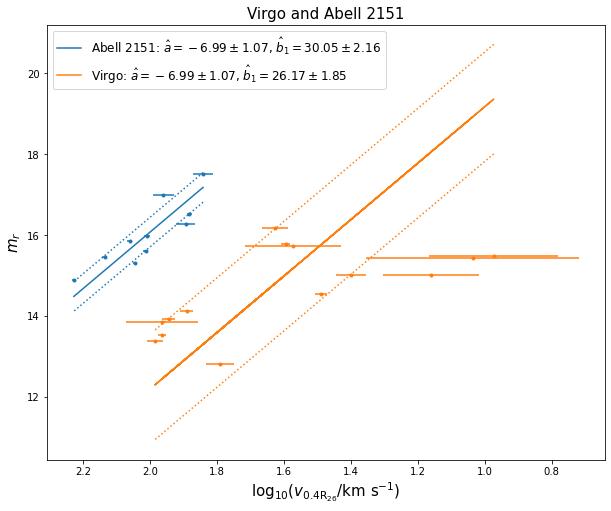

In [92]:
a_, b1_, b2_, sig1_, sig2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]


fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.invert_xaxis()
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
x_ = np.linspace(np.min(data1[0]), np.max(data1[0]))
ax.plot(x_, a_*x_ + b1_, color=eb1[0].get_color(),
        label=r'Abell 2151: $\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))
ax.plot(x_, a_*x_ + b1_ + sig1_, ls=':', color=eb1[0].get_color())
ax.plot(x_, a_*x_ + b1_ - sig1_, ls=':', color=eb1[0].get_color())

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')

x_ = np.linspace(np.min(data2[0]), np.max(data2[0]))
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'Virgo: $\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))
ax.plot(x_, a_*x_ + b2_ + sig2_, ls=':', color=eb2[0].get_color())
ax.plot(x_, a_*x_ + b2_ - sig2_, ls=':', color=eb2[0].get_color())
ax.set_ylabel(r"$m_r$", fontsize = 15.0)
ax.set_xlabel(r"$\log_{10}{(v_\mathrm{0.4R_{26}} / \mathrm{km~s^{-1}})}$", fontsize= 15.0)
ax.set_title('Virgo and Abell 2151', fontsize = 15.0)

#ax.set(xlabel=r"$\log_{10}{(v_\mathrm{0.4R_{26}} / \mathrm{km~s^{-1}})}$", ylabel=r"$m_r$",
       #title='Virgo and Abell 2151', fontsize = 20.0)
ax.legend(fontsize=12);

In [93]:
class MultiLinFit:
    
    def __init__(self, datasets, covs, weights=None, vertaxis=-1):
        
        self.nsets = len(datasets)
        self.ndims = np.shape(datasets[0])[0]
        self.ndata = [np.shape(data)[1] for data in datasets]
        self.datasets = datasets
        self.covs = covs
        self.data = None
        self.cov = None
        
        self.npars = 1 + self.nsets # slope + intercepts + sigmas
        self.params = np.zeros(self.npars)
        self.params_scatter = np.zeros(self.nsets)
        
        self.weights = [np.ones(n) for n in self.ndata] if weights is None else weights
        self.vertaxis = vertaxis
        
        self.param_bounds = None      # parameter fit bounds for all data sets
        
    def _lnpost(self, params):
        lnpost = 0.

        for i in range(self.nsets):
            # Loop over individual data sets. 
            self.data = self.datasets[i]
            self.cov  = self.covs[i]
            
            # Set up parameter and bounds arrays for each data set.
            pars_i = np.array([params[0]] + [params[1+i]] + [params[self.nsets+1+i]])
            bounds_i = [self.param_bounds[0]] + \
                       [self.param_bounds[1+i]] + \
                       [self.param_bounds[self.nsets+1+i]]

            # Set up weights for each data set.
            weights = self.weights[i]
            
            # Sum over all data sets.
            lnprior = self._lnprior(pars_i, bounds_i)
            lnlike = self._lnlike(pars_i)                
            lnpost += np.sum(weights * lnlike) + lnprior
        
        return lnpost
                    
    def _lnprior(self, params, bounds):
        lnprior = 0.
        for i, (param, bound) in enumerate(zip(params.T, bounds)):
            lnprior += np.where(np.logical_or(param < bound[0], param > bound[1]), -np.inf, 0.0)

        return lnprior
    
    def _lnlike(self, params):
        a, b, sigma = params

        x, dx2 = self.data[0], self.cov[0,0]
        y, dy2 = self.data[1], self.cov[1,1]
        dxy = self.cov[0,1]
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        lnlike = 0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b)**2/sy2)

        return lnlike
    
    def optimize(self, bounds, tol=1e-6, verbose=False):
        self.param_bounds = bounds
        res = differential_evolution(lambda *args: -self._lnpost(*args), self.param_bounds, tol=tol)

        if verbose:
            print(res)
            
        self.params = res.x[:-self.nsets]
        self.params_scatter = np.fabs(res.x[-self.nsets:])
        return self.params, self.params_scatter, res.fun
    
    def emcee(self, bounds, max_iter=100000, batchsize=1000, ntau=50.0, tautol=0.05, verbose=False):

        # Set up emcee. Start the walkers in a small 1 percent ball around the best fit.
        # The best fit will set self.params and self.params_scatter.
        self.optimize(bounds, verbose=verbose)
        ndim = len(self.params) + len(self.params_scatter)
        nwalker = 4 * ndim
        seeds = np.asarray([
            [(0.01 * np.random.rand() + 0.995) * j for j in np.concatenate([self.params, self.params_scatter])]
            for _ in range(nwalker)
        ])

        sampler = emcee.EnsembleSampler(nwalker, ndim, self._lnpost)

        old_tau = np.inf
        niter = 0
        converged = 0
        while ~converged:
            sampler.run_mcmc(seeds, nsteps=batchsize, progress=verbose)
            tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
            converged = np.all(ntau * tau < niter)
            converged &= np.all(np.abs(old_tau - tau) / tau < tautol)
            old_tau = tau
            begin = None
            niter += 1000
            if verbose:
                print("Niterations/Max Iterations: ", niter, "/", max_iter)
                print("Integrated ACT/Min Convergence Iterations: ", tau, "/", np.amax(ntau * tau))
            if niter >= max_iter:
                break

        # Remove burn-in and and save the samples
        tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
        burnin = int(2 * np.max(tau))
        samples = sampler.get_chain(discard=burnin, flat=True).T
        mcmc_samples = samples
        mcmc_lnlike = sampler.get_log_prob(discard=burnin, flat=True)

        return mcmc_samples, mcmc_lnlike

In [370]:
mlf = MultiLinFit([data1, data2], [cov1, cov2])

In [371]:
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.], [0., 2.]]
mlf.optimize(bounds, verbose=True)

     fun: -149.65362970575265
     jac: array([ 4.32009986e-04, -1.08286714e-03, -6.84963201e-04, -1.13686838e-05,
       -7.55670731e+01])
 message: 'Optimization terminated successfully.'
    nfev: 7911
     nit: 104
 success: True
       x: array([7.16550423, 1.64939846, 2.76646627, 1.50756169, 2.        ])


(array([7.16550423, 1.64939846, 2.76646627]),
 array([1.50756169, 2.        ]),
 -149.65362970575265)

In [372]:
# Run an MCMC
bounds = [[-10., 10.], [-10., 40.], [-10., 30.], [0., 2.], [0., 2.]]
mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=10000, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: -423.6978266238501
     jac: array([-0.00071623, -0.00286491,  0.0017053 ,  0.00014779,  0.0018531 ])
 message: 'Optimization terminated successfully.'
    nfev: 7479
     nit: 98
 success: True
       x: array([-6.84769434, 29.76373685, 25.93109409,  0.3600179 ,  1.32430091])


100%|██████████| 1000/1000 [00:03<00:00, 257.39it/s]


Niterations/Max Iterations:  1000 / 10000
Integrated ACT/Min Convergence Iterations:  [40.91880342 40.69258855 41.55491708 36.29803164 38.18813547] / 2077.7458540952334


100%|██████████| 1000/1000 [00:03<00:00, 267.84it/s]


Niterations/Max Iterations:  2000 / 10000
Integrated ACT/Min Convergence Iterations:  [45.77837297 45.75705075 47.79330061 43.58949869 54.36377629] / 2718.1888145334215


100%|██████████| 1000/1000 [00:03<00:00, 259.60it/s]


Niterations/Max Iterations:  3000 / 10000
Integrated ACT/Min Convergence Iterations:  [54.73947238 54.52643753 53.92030316 46.16724986 61.95272154] / 3097.6360772104686


100%|██████████| 1000/1000 [00:03<00:00, 266.24it/s]


Niterations/Max Iterations:  4000 / 10000
Integrated ACT/Min Convergence Iterations:  [61.65775853 61.77973696 61.19863378 45.32260099 56.75796203] / 3088.986848059081


100%|██████████| 1000/1000 [00:03<00:00, 271.18it/s]


Niterations/Max Iterations:  5000 / 10000
Integrated ACT/Min Convergence Iterations:  [63.54337044 63.63805454 63.32805261 53.99275786 55.33571454] / 3181.9027271716996


100%|██████████| 1000/1000 [00:03<00:00, 260.19it/s]


Niterations/Max Iterations:  6000 / 10000
Integrated ACT/Min Convergence Iterations:  [60.05297357 60.06172355 59.50472258 53.85089603 56.43221227] / 3003.086177738363


100%|██████████| 1000/1000 [00:03<00:00, 267.78it/s]


Niterations/Max Iterations:  7000 / 10000
Integrated ACT/Min Convergence Iterations:  [55.34712023 55.365162   54.43287977 55.96433086 51.13431924] / 2798.216542850635


100%|██████████| 1000/1000 [00:03<00:00, 269.73it/s]


Niterations/Max Iterations:  8000 / 10000
Integrated ACT/Min Convergence Iterations:  [55.0628583  54.95982686 55.40851335 53.15763836 53.47679971] / 2770.4256673555396


100%|██████████| 1000/1000 [00:03<00:00, 265.86it/s]


Niterations/Max Iterations:  9000 / 10000
Integrated ACT/Min Convergence Iterations:  [52.08732792 51.88558001 52.38209298 56.68165059 53.06530556] / 2834.082529618288


100%|██████████| 1000/1000 [00:03<00:00, 261.49it/s]


Niterations/Max Iterations:  10000 / 10000
Integrated ACT/Min Convergence Iterations:  [56.33801165 55.87854136 56.48917761 59.29446272 56.23654066] / 2964.7231358305467
[-6.94002322 29.94977654 26.08226958  0.37215087  1.36011402] [0.33045707 0.66648458 0.55830353 0.03299376 0.11709263]


In [373]:
a, b1, b2, sig1, sig2    = np.mean(mcmc_samples, axis=1)
da, db1, db2, dsig1, dsig2 = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b1, b2, sig1, sig2), (da, db1, db2, dsig1, dsig2)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -6.94 +/- 0.33
 29.95 +/- 0.67
 26.08 +/- 0.56
  0.37 +/- 0.03
  1.36 +/- 0.12


10
14


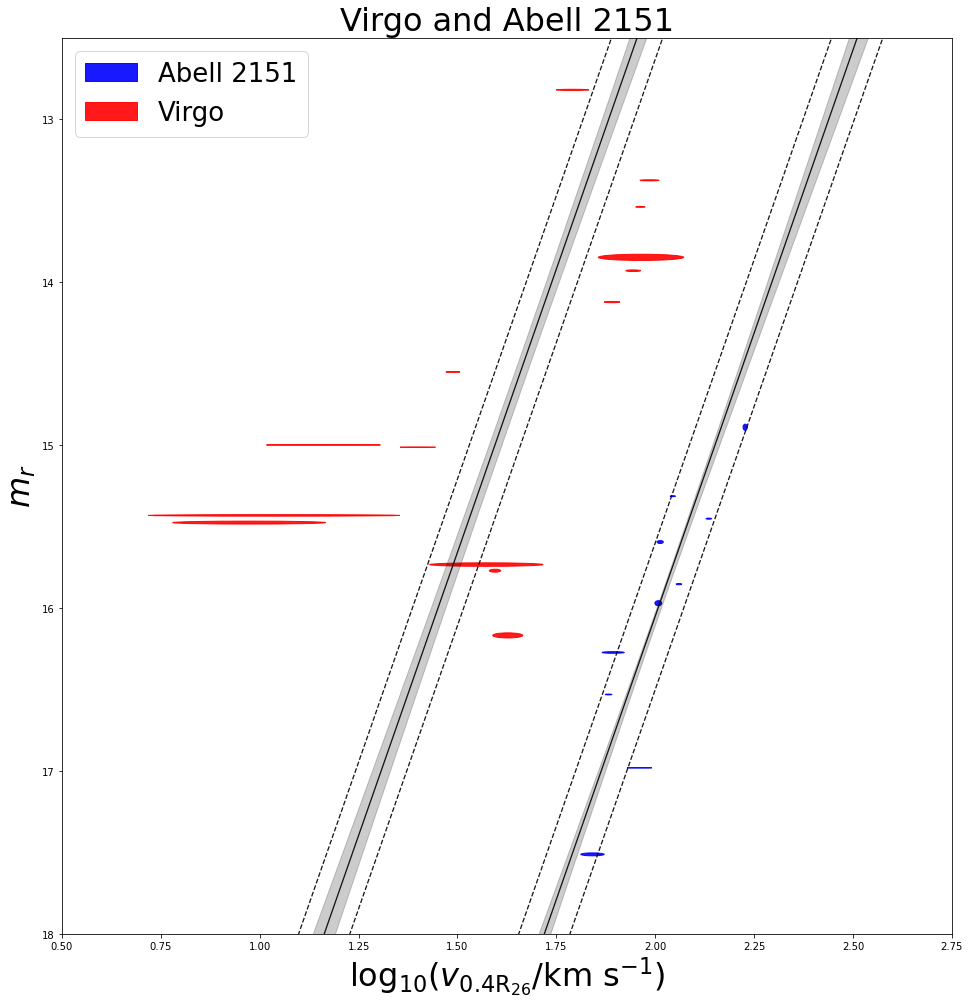

In [385]:
xvals = np.linspace(0., 3., 1000)
yvals1 = a * xvals + b1
yvals2 = a * xvals + b2

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain1 = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles1 = np.quantile(y_chain1, [0.1587, 0.8414], axis=1)

y_chain2 = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[2]
y_chain_quantiles2 = np.quantile(y_chain2, [0.1587, 0.8414], axis=1)

# Pack info into data
x_err1 = np.sqrt(cov1[0][0])
y_err1 = np.sqrt(cov2[1][1])
corr_xy1 = np.zeros_like(x_err1)

x_err2 = np.sqrt(cov2[0][0])
y_err2 = np.sqrt(cov2[1][1])
corr_xy2 = np.zeros_like(x_err2)


# Generate ellipses
ells1 = [
    Ellipse(
        xy=[data1[0][i], data1[1][i]],
        width=2.0 * y_err1[i],
        height=2.0 * x_err1[i],
        angle=np.rad2deg(np.arccos(corr_xy1[i])),
    )
    for i in range(len(data1[0]))
]

ells2 = [
    Ellipse(
        xy=[data2[0][i], data2[1][i]],
        width=2.0 * y_err2[i],
        height=2.0 * x_err2[i],
        angle=np.rad2deg(np.arccos(corr_xy2[i])),
    )
    for i in range(len(data2[0]))
]


print(len(ells1))
print(len(ells2))


# Make the plot
fig = plt.figure(figsize=(12,15))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
for i, e in enumerate(ells1):
    ax.add_artist(e)
    e.set_color('blue')
    e.set_edgecolor('blue')
    e.set_alpha(0.9)

e.set_label('Abell 2151')
for i, e in enumerate(ells2):
    ax.add_artist(e)
    e.set_color('red')
    e.set_edgecolor('red')
    e.set_alpha(0.9)

e.set_label('Virgo')
ax.fill_between(xvals, y_chain_quantiles1[0], y_chain_quantiles1[1], color="k", alpha=0.2)
ax.fill_between(xvals, y_chain_quantiles2[0], y_chain_quantiles2[1], color="k", alpha=0.2)
ax.plot(xvals, -6.95*xvals + b1, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, -6.95*xvals + b1 - vert1, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, -6.95*xvals + b1 + vert1, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, -6.95*xvals + b2, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, -6.95*xvals + b2 - vert2, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, -6.95*xvals + b2 + vert2, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.set_xlabel(r"$\log_{10}{(v_\mathrm{0.4R_{26}} / \mathrm{km~s^{-1}})}$", fontsize=32)
ax.set_ylabel(r"$m_r$", fontsize=32)
ax.set_title(r"Virgo and Abell 2151", fontsize=32)
ax.set_xlim(0.5, 2.75)
ax.set_ylim(18, 12.5)

ax.legend(fontsize=26)

# Add the colourbar
#cb = fig.colorbar(
 #   cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmo.cm.matter),
  #  ax=ax,
   # shrink=0.4,
    #aspect=10,
    #anchor=(-7.2, 0.95),
#)
#cb.set_label(label=r"$\sigma$", fontsize=14)

plt.savefig('virgo&a2151.png', bbox_inches='tight')

In [254]:
from scipy.stats import linregress

In [257]:
linregress(xvals, -6.95*xvals + b1)

LinregressResult(slope=-6.95, intercept=29.971075913924246, rvalue=-1.0, pvalue=0.0, stderr=0.0, intercept_stderr=0.0)

In [ ]:
sigmas = hf.get_sigmas()
xvals = np.linspace(0., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [log10vmax[isrmeas], rmag[isrmeas]]
x_err = dlog10vmax[isrmeas]
y_err = drmag[isrmeas]
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2.0 * y_err[i],
        height=2.0 * x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig = plt.figure(figsize=(6,7))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(cmo.cm.haline(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.set_xlabel(r"$\log_{10}{(v_\mathrm{0.4R_{26}} / \mathrm{km~s^{-1}})}$", fontsize=16)
ax.set_ylabel(r"$m_r$", fontsize=16)
ax.set_title(r"Virgo", fontsize=16)
ax.set_xlim(0, 3)
ax.set_ylim(18, 12)

# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmo.cm.haline),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-8, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=14)

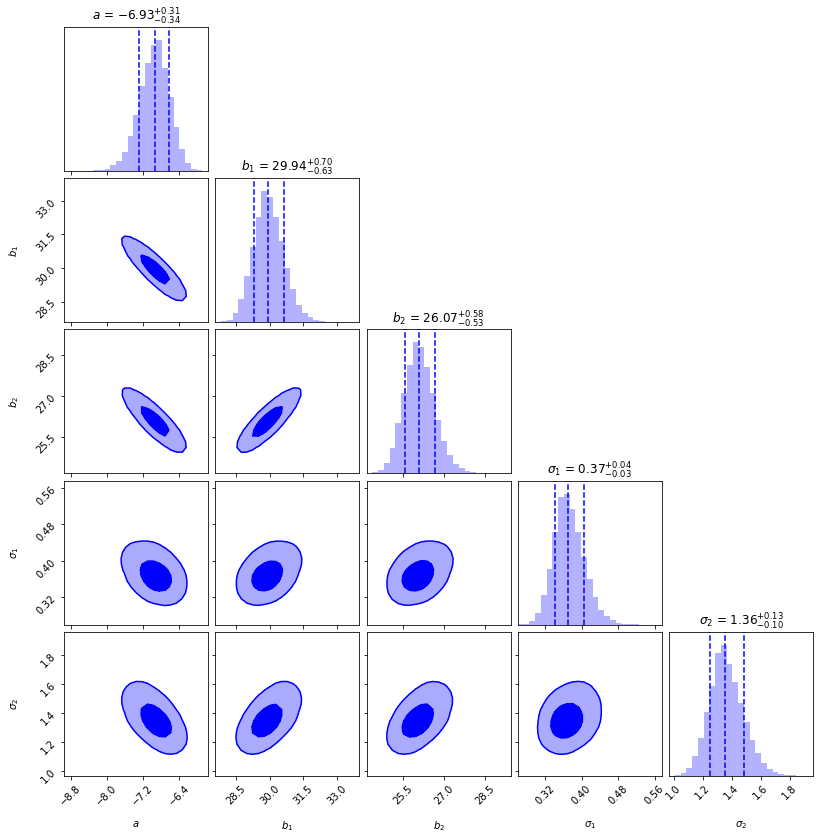

In [98]:
fig = corner.corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b_1$', '$b_2$', r'$\sigma_1$', r'$\sigma_2$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})
plt.savefig('cornerplot.png')

### Calibration 

In [386]:
SGA_IDs = tdaily['SGA_ID']

In [387]:
SGA = Table.read('/global/homes/h/hnofi/DESI_SGA/TF/SGA_distances.fits', format = 'fits')

In [388]:
t = join(SGA_main, SGA, keys_left='SGA_ID_1', keys_right='SGA_ID')
t

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID_1,RA_1,DEC_1,SGA_ID_2,SGA_GALAXY_1,GALAXY_1,PGC_1,RA_LEDA_1,DEC_LEDA_1,MORPHTYPE_1,PA_LEDA_1,D25_LEDA_1,BA_LEDA_1,Z_LEDA_1,SB_D25_LEDA_1,MAG_LEDA_1,BYHAND_1,REF_1,GROUP_ID_1,GROUP_NAME_1,GROUP_MULT_1,GROUP_PRIMARY_1,GROUP_RA_1,GROUP_DEC_1,GROUP_DIAMETER_1,BRICKNAME_1,RA_2,DEC_2,D26_1,D26_REF_1,PA_1,BA_1,RA_MOMENT_1,DEC_MOMENT_1,SMA_MOMENT_1,G_SMA50_1,R_SMA50_1,Z_SMA50_1,SMA_SB22_1,SMA_SB22.5_1,SMA_SB23_1,SMA_SB23.5_1,SMA_SB24_1,SMA_SB24.5_1,SMA_SB25_1,SMA_SB25.5_1,SMA_SB26_1,G_MAG_SB22_1,R_MAG_SB22_1,Z_MAG_SB22_1,G_MAG_SB22.5_1,R_MAG_SB22.5_1,Z_MAG_SB22.5_1,G_MAG_SB23_1,R_MAG_SB23_1,Z_MAG_SB23_1,G_MAG_SB23.5_1,R_MAG_SB23.5_1,Z_MAG_SB23.5_1,G_MAG_SB24_1,R_MAG_SB24_1,Z_MAG_SB24_1,G_MAG_SB24.5_1,R_MAG_SB24.5_1,Z_MAG_SB24.5_1,G_MAG_SB25_1,R_MAG_SB25_1,Z_MAG_SB25_1,G_MAG_SB25.5_1,R_MAG_SB25.5_1,Z_MAG_SB25.5_1,G_MAG_SB26_1,R_MAG_SB26_1,Z_MAG_SB26_1,SMA_SB22_ERR_1,SMA_SB22.5_ERR_1,SMA_SB23_ERR_1,SMA_SB23.5_ERR_1,SMA_SB24_ERR_1,SMA_SB24.5_ERR_1,SMA_SB25_ERR_1,SMA_SB25.5_ERR_1,SMA_SB26_ERR_1,G_MAG_SB22_ERR_1,R_MAG_SB22_ERR_1,Z_MAG_SB22_ERR_1,G_MAG_SB22.5_ERR_1,R_MAG_SB22.5_ERR_1,Z_MAG_SB22.5_ERR_1,G_MAG_SB23_ERR_1,R_MAG_SB23_ERR_1,Z_MAG_SB23_ERR_1,G_MAG_SB23.5_ERR_1,R_MAG_SB23.5_ERR_1,Z_MAG_SB23.5_ERR_1,G_MAG_SB24_ERR_1,R_MAG_SB24_ERR_1,Z_MAG_SB24_ERR_1,G_MAG_SB24.5_ERR_1,R_MAG_SB24.5_ERR_1,Z_MAG_SB24.5_ERR_1,G_MAG_SB25_ERR_1,R_MAG_SB25_ERR_1,Z_MAG_SB25_ERR_1,G_MAG_SB25.5_ERR_1,R_MAG_SB25.5_ERR_1,Z_MAG_SB25.5_ERR_1,G_MAG_SB26_ERR_1,R_MAG_SB26_ERR_1,Z_MAG_SB26_ERR_1,G_COG_PARAMS_MTOT_1,G_COG_PARAMS_M0_1,G_COG_PARAMS_ALPHA1_1,G_COG_PARAMS_ALPHA2_1,G_COG_PARAMS_CHI2_1,R_COG_PARAMS_MTOT_1,R_COG_PARAMS_M0_1,R_COG_PARAMS_ALPHA1_1,R_COG_PARAMS_ALPHA2_1,R_COG_PARAMS_CHI2_1,Z_COG_PARAMS_MTOT_1,Z_COG_PARAMS_M0_1,Z_COG_PARAMS_ALPHA1_1,Z_COG_PARAMS_ALPHA2_1,Z_COG_PARAMS_CHI2_1,ELLIPSEBIT_1,cosi,SGA_ID,SGA_GALAXY_2,GALAXY_2,PGC_2,RA_LEDA_2,DEC_LEDA_2,MORPHTYPE_2,PA_LEDA_2,D25_LEDA_2,BA_LEDA_2,Z_LEDA_2,SB_D25_LEDA_2,MAG_LEDA_2,BYHAND_2,REF_2,GROUP_ID_2,GROUP_NAME_2,GROUP_MULT_2,GROUP_PRIMARY_2,GROUP_RA_2,GROUP_DEC_2,GROUP_DIAMETER_2,BRICKNAME_2,RA,DEC,D26_2,D26_REF_2,PA_2,BA_2,RA_MOMENT_2,DEC_MOMENT_2,SMA_MOMENT_2,G_SMA50_2,R_SMA50_2,Z_SMA50_2,SMA_SB22_2,SMA_SB22.5_2,SMA_SB23_2,SMA_SB23.5_2,SMA_SB24_2,SMA_SB24.5_2,SMA_SB25_2,SMA_SB25.5_2,SMA_SB26_2,G_MAG_SB22_2,R_MAG_SB22_2,Z_MAG_SB22_2,G_MAG_SB22.5_2,R_MAG_SB22.5_2,Z_MAG_SB22.5_2,G_MAG_SB23_2,R_MAG_SB23_2,Z_MAG_SB23_2,G_MAG_SB23.5_2,R_MAG_SB23.5_2,Z_MAG_SB23.5_2,G_MAG_SB24_2,R_MAG_SB24_2,Z_MAG_SB24_2,G_MAG_SB24.5_2,R_MAG_SB24.5_2,Z_MAG_SB24.5_2,G_MAG_SB25_2,R_MAG_SB25_2,Z_MAG_SB25_2,G_MAG_SB25.5_2,R_MAG_SB25.5_2,Z_MAG_SB25.5_2,G_MAG_SB26_2,R_MAG_SB26_2,Z_MAG_SB26_2,SMA_SB22_ERR_2,SMA_SB22.5_ERR_2,SMA_SB23_ERR_2,SMA_SB23.5_ERR_2,SMA_SB24_ERR_2,SMA_SB24.5_ERR_2,SMA_SB25_ERR_2,SMA_SB25.5_ERR_2,SMA_SB26_ERR_2,G_MAG_SB22_ERR_2,R_MAG_SB22_ERR_2,Z_MAG_SB22_ERR_2,G_MAG_SB22.5_ERR_2,R_MAG_SB22.5_ERR_2,Z_MAG_SB22.5_ERR_2,G_MAG_SB23_ERR_2,R_MAG_SB23_ERR_2,Z_MAG_SB23_ERR_2,G_MAG_SB23.5_ERR_2,R_MAG_SB23.5_ERR_2,Z_MAG_SB23.5_ERR_2,G_MAG_SB24_ERR_2,R_MAG_SB24_ERR_2,Z_MAG_SB24_ERR_2,G_MAG_SB24.5_ERR_2,R_MAG_SB24.5_ERR_2,Z_MAG_SB24.5_ERR_2,G_MAG_SB25_ERR_2,R_MAG_SB25_ERR_2,Z_MAG_SB25_ERR_2,G_MAG_SB25.5_ERR_2,R_MAG_SB25.5_ERR_2,Z_MAG_SB25.5_ERR_2,G_MAG_SB26_ERR_2,R_MAG_SB26_ERR_2,Z_MAG_SB26_ERR_2,G_COG_PARAMS_MTOT_2,G_COG_PARAMS_M0_2,G_COG_PARAMS_ALPHA1_2,G_COG_PARAMS_ALPHA2_2,G_COG_PARAMS_CHI2_2,R_COG_PARAMS_MTOT_2,R_COG_PARAMS_M0_2,R_COG_PARAMS_ALPHA1_2,R_COG_PARAMS_ALPHA2_2,R_COG_PARAMS_CHI2_2,Z_COG_PARAMS_MTOT_2,Z_COG_PARAMS_M0_2,Z_COG_PARAMS_ALPHA1_2,Z_COG_PARAMS_ALPHA2_2,Z_COG_PARAMS_CHI2_2,ELLIPSEBIT_2,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64,int64,bytes16,bytes29,int64,float64,float6

In [402]:
for i in range(0, len(t)):
    if (t['SN_Catalog'][i] == '-1') & (t['Stellar_Catalog'][i] == '-1'):
        t.remove_row(i)

In [403]:
# All targets
_ids_all, _counts_all = np.unique(t['SGA_ID'], return_counts=True)
_ids_all[_counts_all > 1]

109750
399255
431725
463355
501697
617559
635598
656304


#### Remove Galaxy: 501697

In [406]:
for i in range(0, len(t)):
    if (t['SGA_ID_1'][i] == 501697):
        t.remove_row(i)

In [407]:
sga_ids_vel_cuts = []
rmag = []
rmag_err = []
abs_mag = []
abs_mag_err = []
vmax = []
dvmax = []

for i, sga_id in enumerate(t['SGA_ID_1']):
    # if sga_id == 474614:
    #     print('skipped')
    #     continue
    galaxy_list = t[t['SGA_ID_1'] == sga_id]
    print
    #print(i+1, sga_id)
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    r26 = 0.5 * float(sga_galaxy['D26_1'])*u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26
    
    zc, zc_err = sga_galaxy['Z'], sga_galaxy['ZERR']
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = c * dz
    dv_err = c * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26])
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2))

            rmag.append(float(sga_galaxy['R_MAG_SB26_1']))
            rmag_err.append(float(sga_galaxy['R_MAG_SB26_ERR_1']))
            vmax.append(v033)
            dvmax.append(dv033)
            # Find absolute magnitude - 5log(h), using h=0.742 (Union2 (2010))
            abs_mag.append(float(sga_galaxy['R_MAG_SB26_1'] - sga_galaxy['DM1_SN']) - 5*np.log10(0.742))
            abs_mag_err.append(np.sqrt((float(sga_galaxy['R_MAG_SB26_ERR_1']))**2 + (float(sga_galaxy['e_DM1_SN']))**2))
            sga_ids_vel_cuts.append(sga_id)
            
#print(sga_ids_vel_cuts)
#print('mag:', rmag)
#print('vel:', vmax)
#print('dv:', dvmax)

36


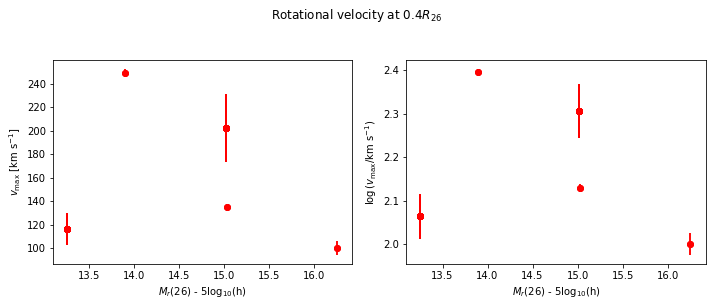

In [408]:
rmag = np.asarray(rmag)
rmag_err = np.asarray(rmag_err)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)
abs_mag = np.asarray(abs_mag)
abs_mag_err = np.asarray(abs_mag_err)

isrmeas = rmag > 0

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(rmag[isrmeas], vmax[isrmeas], xerr = rmag_err[isrmeas], yerr=dvmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26) - 5log$_{10}$(h)',
       #xlim=(18.5, 12.5),
       #ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(rmag[isrmeas], log10vmax[isrmeas], xerr = rmag_err[isrmeas], yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26) - 5log$_{10}$(h)',
       #xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$')
       #ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.4R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

36


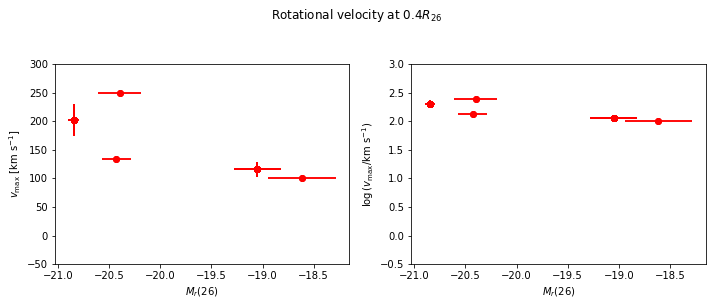

In [409]:
rmag = np.asarray(rmag)
vmax = np.asarray(vmax)
dvmax = np.asarray(dvmax)
abs_mag = np.asarray(abs_mag)
abs_mag_err = np.asarray(abs_mag_err)
# abs_mag_err = np.sqrt()

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

ax = axes[0]
ax.errorbar(abs_mag, vmax, xerr = abs_mag_err,yerr=dvmax, fmt='ro')
ax.set(xlabel='$M_r$(26)',
       # xlim=(18.5, 12.5),
       ylim=(-50,300),
       ylabel='$v_\mathrm{max}$ [km s$^{-1}$]')

ax = axes[1]

log10vmax = np.log10(vmax)
dlog10vmax = 0.434 * dvmax / vmax 

ax.errorbar(abs_mag[isrmeas], log10vmax[isrmeas], xerr = abs_mag_err[isrmeas],yerr=dlog10vmax[isrmeas], fmt='ro')
ax.set(xlabel='$M_r$(26)',
       # xlim=(18.5, 12.5),
       ylabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
       ylim=(-0.5,3))

fig.suptitle(r'Rotational velocity at $0.4R_{26}$', y=1.05)
fig.subplots_adjust(top=0.8)

print(np.sum(isrmeas))

In [410]:
sga_table = t

In [411]:
rmag_clean = []
rmag_err_clean = []
vmax_clean = []
dvmax_clean = []
abs_mag_clean = []
abs_mag_err_clean = []
z= []

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

sga_table['cosi'] = np.sqrt((sga_table['BA_1']**2 - q0**2)/(1 - q0**2))
sga_table['cosi'][np.isnan(sga_table['cosi'])] = 0 # Objects with b/a < 0.2

#i = 0

for sga_id in np.unique(sga_table['SGA_ID_1']):
    galaxy_list = sga_table[sga_table['SGA_ID_1'] == sga_id]
    
    is_sga_galaxy = (galaxy_list['TARGETID'] > 30000000000000000) & (galaxy_list['TARGETID'] < 40000000000000000)
    sga_galaxy = galaxy_list[is_sga_galaxy]
    tf_list = galaxy_list[~is_sga_galaxy]
    
    if np.sum(is_sga_galaxy) > 1:
        sga_galaxy = sga_galaxy[0]
    
    targetid = int(sga_galaxy['TARGETID'])
    
    center = SkyCoord(sga_galaxy['TARGET_RA'], sga_galaxy['TARGET_DEC'], unit='deg')
    offcenter = SkyCoord(tf_list['TARGET_RA'], tf_list['TARGET_DEC'], unit='deg')
    sep2d = offcenter.separation(center)
    
    morphtype = str(sga_galaxy['MORPHTYPE_1'])
    
    cosi = float(sga_galaxy['cosi'])
    
    r26 = 0.5 * float(sga_galaxy['D26_1']) * u.arcmin
    sep_r26 = sep2d.to('arcmin') / r26

    # Cut any suspected ellipticals
    if morphtype.startswith('E') or morphtype.startswith('S0') or morphtype.startswith('I'):
        print('{} cut (morphology)'.format(sga_id))
        continue
               
    # Inclination cut
    if cosi > cosi_max:
        print('{} cut (inclination)'.format(sga_id))
        continue
        
    #i += 1
    #print(i, sga_id, cosi)
    
    zc, zc_err = float(sga_galaxy['Z']), float(sga_galaxy['ZERR'])
    zt, zt_err = tf_list['Z'], tf_list['ZERR']
    
    dz = np.abs(zt - zc)
    dz_err = np.sqrt(zc_err**2 + zt_err**2)
    
    dv = 3e5 * dz
    dv_err = 3e5 * dz_err
    
    good_vel = dv < 5000
    
    if np.sum(good_vel) > 0:
    
        sep_r26 = np.insert(sep_r26[good_vel], 0, 0.)
        dv = np.insert(dv[good_vel], 0, 0.)
        dv_err = np.insert(dv_err[good_vel], 0, 3e5*zc_err)

        # Extract the 0.33xR26 points.
        is_033_r26 = (sep_r26 > 0.35) & (sep_r26 < 0.45)
        
        if np.sum(is_033_r26) > 0:
            v033 = np.mean(dv[is_033_r26]) / np.sqrt(1 - cosi**2)
            dv033 = np.sqrt(np.sum(dv_err[is_033_r26]**2)) / np.sqrt(1 - cosi**2)
            z.append(zc)
            rmag_clean.append(float(sga_galaxy['R_MAG_SB26_1']))
            rmag_err_clean.append(float(sga_galaxy['R_MAG_SB26_ERR_1']))
            vmax_clean.append(v033)
            dvmax_clean.append(dv033)
            abs_mag_clean.append(float(sga_galaxy['R_MAG_SB26_1'] - sga_galaxy['DM1_SN'] - 5*np.log10(0.742)))
            abs_mag_err_clean.append(np.sqrt((float(sga_galaxy['R_MAG_SB26_ERR_1']))**2 + (float(sga_galaxy['e_DM1_SN']))**2))
    
#inComa_sga_table[['SGA_ID', 'BA', 'cosi']].show_in_notebook()
print(len(rmag_clean))

5


In [414]:
def l1norm(pars, x, y, dy):
    '''
    Linear fit that uses the l1-norm (robust against outliers).
    '''
    a, b = pars
    return np.sum(np.abs((y - a - b*x)/dy))

def l1norm_noerror(pars, x, y):
    '''
    Linear fit that uses the l1-norm without normalizing by measurement uncertainties.
    '''
    a, b = pars
    return np.sum(np.abs(y - a - b*x))

def l2norm(pars, x, y, dy):
    '''
    Linear fit that uses the l2-norm
    '''
    a, b = pars
    return np.sum((y - a - b*x)**2/dy**2)

def fit_tfr(r, logv, dlogv):
    fmin = 1e99
    a, b = -0.5, -0.15
    hess_inv = np.ones((2,2))
    
    succ_res = None
    
    # Try a large number of random seeds to ensure a decent fit.
    for i in range(1000):
        _a, _b = np.random.uniform(-1,1), np.random.uniform(-0.14306432,-0.14306432)
        
        res = minimize(l1norm_noerror, 
                       [_a, _b], 
                       args=(r,logv),# dlogv),
                       method='L-BFGS-B', 
                       bounds=[[-1,1], [-0.14306432,-0.14306432]])
        
        if res.fun < fmin and res.success:
            # print('Successful fit')
            succ_res = res.copy()
            fmin = res.fun
            a, b = res.x
            hess_inv = res.hess_inv
    
    if succ_res is None:
        print('No successful fits')
    # else:
    #     print(succ_res)
    
    return a, b, hess_inv

In [415]:
abs_mag_clean = np.asarray(abs_mag_clean)
abs_mag_err_clean = np.asarray(abs_mag_err_clean)
vmax_clean = np.asarray(vmax_clean)
dvmax_clean = np.asarray(dvmax_clean)

log10vmax_clean = np.log10(vmax_clean)
dlog10vmax_clean = 0.434 * dvmax_clean / vmax_clean 

a, b, hess_inv = fit_tfr(abs_mag_clean, 
                  log10vmax_clean, 
                  dlog10vmax_clean)

print('Fitted params: a={0}, b={1}'.format(a, b))
print('Slope={0}, y-int={1}'.format(1/b, -a/b))

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


Fitted params: a=-0.6193788137772376, b=-0.14306432
Slope=-6.989863021052349, y-int=-4.3293730664447825


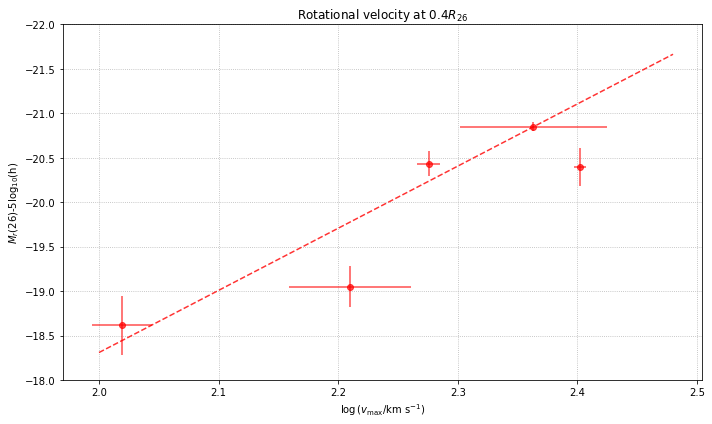

In [416]:
fig, ax = plt.subplots(1,1, figsize=(10,6), tight_layout=True)

ax.errorbar(log10vmax_clean, 
            abs_mag_clean,
            yerr = abs_mag_err_clean,
            xerr=dlog10vmax_clean, 
            fmt='ro', 
            alpha=0.7,
            label='Cleaned data, $\cos{(i)}$-corrected')

# a = -0.75655391
# b = -0.14665

logv = np.arange(2, 2.5, 0.03)
ax.plot(logv, 1/b * (logv - a), 'r--', alpha=0.8)
# ################################################################################


ax.set(ylabel='$M_r$(26)-5log$_{10}$(h)',
       #ylim=(-18, -38),
       xlabel=r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$',
        ylim=(-18, -22),
       title=r'Rotational velocity at $0.4R_{26}$')
ax.grid(ls=':')
# ax.legend(loc='upper left', fontsize=10);

# fig.suptitle(r'Max velocity at $0.33\times R_{26}$', y=1.05)
# fig.subplots_adjust(top=0.8)
#fig.savefig('tf_dist_04_06_2022.png', dpi=120, transparent=True)

# print(np.sum(isrmeas))

In [417]:
# Create a 2x2xN matrix.
ndata = len(dlog10vmax_clean)
cov3 = np.empty((2, 2, ndata))

# loop over arrays of uncertainties in logv and mag
# Assume diagonal covariance for each measurement.
for i, (dlogv, dm) in enumerate(zip(dlog10vmax_clean, abs_mag_err_clean)):
    cov3[:,:,i] = np.array([[dlogv**2, 0.], [0., dm**2]])
                              
# cov[:,:,0]

In [419]:
logv = log10vmax_clean
mr = abs_mag_clean
logv.shape, mr.shape

((5,), (5,))

In [420]:
data3 = [logv, mr]
cov3 = cov3

In [421]:
hf = LinFit([logv, mr], cov3)

In [422]:
bounds = ((-6.99, -6.98), (-10.0, 10.0), (1.0e-5, 500.0))
mcmc_samples, mcmc_lnlike = hf.emcee(bounds)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis = 1))

[-6.65272482 -4.90487806  0.6666957 ] [0.67888107 1.52609688 0.59310329]


In [423]:
a, b, sig    = np.mean(mcmc_samples, axis=1)
da, db, dsig = np.std(mcmc_samples, axis=1)

for val, err in zip((a, b, sig), (da, db, dsig)):
    print('{:6.2f} +/- {:.2f}'.format(val, err))

 -6.65 +/- 0.68
 -4.90 +/- 1.53
  0.67 +/- 0.59


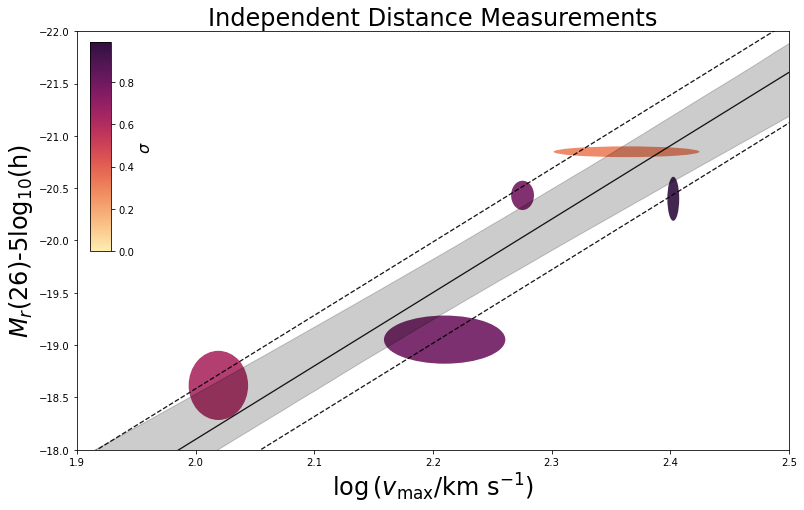

In [431]:
sigmas = hf.get_sigmas()
xvals = np.linspace(0., 3., 1000)
yvals = hf.coords[0] * xvals + hf.coords[1]

# Get the MCMC 1-sigma quantiles to plot with the fit.
y_chain = np.outer(xvals, mcmc_samples[0]) + mcmc_samples[1]
y_chain_quantiles = np.quantile(y_chain, [0.1587, 0.8414], axis=1)

# Pack info into data
data = [log10vmax_clean, abs_mag_clean, ]
x_err = dlog10vmax_clean
y_err = abs_mag_err_clean 
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2.0 * y_err[i],
        height=2.0 * x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0.15, 0.15, 1.03, 0.83])
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_color(cmo.cm.matter(sigmas[i] / np.amax(sigmas)))
    e.set_edgecolor('None')
    e.set_alpha(0.9)
ax.fill_between(xvals, y_chain_quantiles[0], y_chain_quantiles[1], color="k", alpha=0.2)
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals - hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.plot(xvals, yvals + hf.vert_scat, c="k", marker="None", ls="--", lw=1.3, alpha=0.9)
ax.set_xlabel(r'$\log{(v_\mathrm{max} / \mathrm{km~s}^{-1})}$', fontsize=24)
ax.set_ylabel('$M_r$(26)-5log$_{10}$(h)', fontsize=24)
ax.set_title(r"Independent Distance Measurements", fontsize=24)
ax.set_xlim(1.9, 2.5)
ax.set_ylim(-18, -22)

# Add the colourbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0.0, vmax=np.amax(sigmas)), cmap = cmo.cm.matter),
    ax=ax,
    shrink=0.5,
    aspect=10,
    anchor=(-6.6, 0.95),
)
cb.set_label(label=r"$\sigma$", fontsize=16)
plt.savefig('inddist.png', bbox_inches='tight')

Text(0.5, 1.0, 'Hyperfit MCMC Y-Intercept Values')

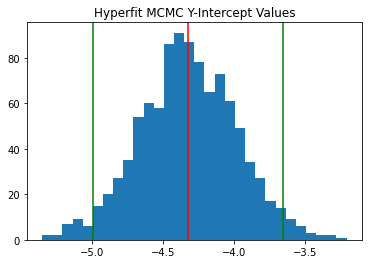

In [196]:
plt.hist(yrand, bins = 30)
#plt.xlim(-3,-6)
plt.axvline(yrand.mean(), ymin=-1, ymax=15, color='red', label='mean')
plt.axvline(x=yrand.mean() - sty * 1.96, ymin=-1, ymax=15, color='green', label='95% CI')
plt.axvline(x=yrand.mean() + sty * 1.96, ymin=-1, ymax=15, color='green')
plt.title('Hyperfit MCMC Y-Intercept Values')